# Stochastic processes course 2018/2019-2 @ ELTE
# Assignment 7: Ising model simulation with Monte Carlo method
## 03.30.2019

# Initial parameters and theory

Characteristic parameters of the system (for me):


$$
\beta J = \frac{J}{k_{B} T} = \left\{ 0.12,\ 0.24,\ 0.75,\ 1.60 \right\} \quad - \quad \text{Pál Balázs}
$$

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
import random
import seaborn as sns
from matplotlib.patches import Circle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statistics
from scipy.optimize import curve_fit

sns.set_style(style='whitegrid')

image_path = '.\\Documentation\\src\\images\\'
image_format = 'pdf'
image_dpi = 150

## Characteristic parameters of the system

In [73]:
# Boltzmann constant
k_B = 1.380648e-23

# Number of spins, situated on the 1D lattice
N_spin_1D = 300

# Number of spins in a row at the 2D case
N_spin_2D = 40

# Arbitrary J
J = 5e-22

# Scale factor for the microscopic system
# beta = 1/(k_B * T)
beta_1 = 0.12 / (J)
print('At first case T = {0} K'.format(1 / (beta_1 * k_B)))
beta_2 = 0.24 / (J)
print('At second case T = {0} K'.format(1 / (beta_2 * k_B)))
beta_3 = 0.75 / (J)
print('At third case T = {0} K'.format(1 / (beta_3 * k_B)))
beta_4 = 1.60 / (J)
print('At fourth case T = {0} K'.format(1 / (beta_4 * k_B)))


betas = {'1': beta_1,
         '2': beta_2,
         '3': beta_3,
         '4': beta_4
        }

At first case T = 301.7906567544129 K
At second case T = 150.89532837720645 K
At third case T = 48.286505080706064 K
At fourth case T = 22.634299256580967 K


In [74]:
betas

{'1': 2.4e+20,
 '2': 4.8e+20,
 '3': 1.5000000000000003e+21,
 '4': 3.2000000000000005e+21}

# Ising model simulation on 1D lattice

In [75]:
start_offset_1D = 2000

## 1.: Randomly choose directions for starting position of the spins

In [76]:
def choose_sign():
    return -1 if random.random() < 0.5 else 1

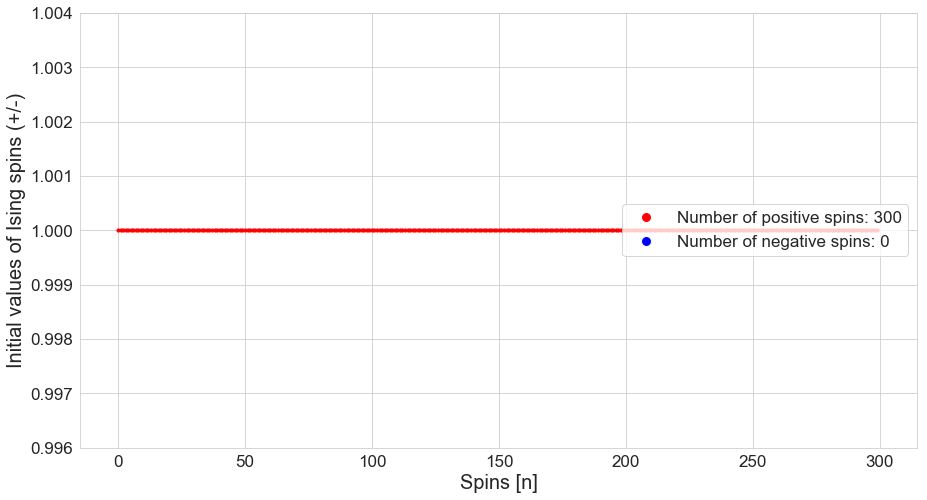

In [77]:
# The current positions of the spins
#Spins_1D = np.array([choose_sign() for i in range(0, N_spin)])
Spins_1D = np.ones((N_spin_1D))
Spins_positive_1D = Spins_1D[Spins_1D>0]
Spins_negative_1D = Spins_1D[Spins_1D<0]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,8))

scattersize = 10
axislabelsize = 20
axisticksize = 17
legendsize = 17

count = 0
for i in range(0, N_spin_1D):
    
    if(Spins_1D[i] > 0):
        axes.scatter(i, Spins_1D[i], color='red', s=scattersize)
    
    elif(Spins_1D[i] < 0):
        axes.scatter(i, Spins_1D[i], color='blue', s=scattersize)

axes.set_xlabel('Spins [n]', fontsize=axislabelsize)
axes.set_ylabel('Initial values of Ising spins (+/-)', fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor='red',
                          markersize=10, label='Number of positive spins: {0}'.format(len(Spins_positive_1D))),
                   Line2D([0], [0], marker='o', color='white', markerfacecolor='blue',
                          markersize=10, label='Number of negative spins: {0}'.format(len(Spins_negative_1D)))]

axes.legend(handles=legend_elements , loc='center right', fontsize=legendsize)

plt.show()

## 2.: $E_{tot.}$ energy of the current state

In [78]:
def E_1D(Spins):
    E = 0
    
    for i in range(0, N_spin_1D-2):
        E += Spins[i] * Spins[i+1]
    
    return E * J

## 3.: Step with the simulation

In [79]:
def simulation_step_1D(beta, steps, Spins):

    # Chronologies for reached energy levels' indeces and actual energies in order
    spin_changes_chronology = np.zeros((steps+1, N_spin_1D), dtype='int')
    energy_chronology = np.zeros((steps+1))
    total_magnetization = np.zeros((steps+1))
    
    # Starting position on X axis
    spin_changes_chronology[0] = Spins
    energy_chronology[0] = E_1D(Spins=Spins)
    total_magnetization[0] = Spins.sum()/len(Spins)

    for current_step in range(0, steps):
        # Choose a random Ising spin from the pool at the start of every step
        choosen_spin_index = np.random.choice([i for i in range(0, N_spin_1D)])
        
        # Rotate it to check the energy difference
        New_Spins = Spins
        New_Spins[choosen_spin_index] *= -1

        # Calculate energy difference between the jump's origin and end points
        E_1 = E_1D(Spins=Spins)

        E_2 = E_1D(Spins=New_Spins)
        
        delta_E = E_2 - E_1

        # Update chronology of reached energies indeces
        # If delta_E <= 0, then execute the flip
        if(delta_E < 0):
            spin_changes_chronology[current_step+1] = New_Spins
            Spins = New_Spins
            # Update chronology of actual reached energy levels
            energy_chronology[current_step+1] = E_2
            
        if(delta_E == 0):
            if(random.random() < 0.5):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

        # If delta_E > 0, choose a random number X, between 0 and 1
        # If X < e^(-beta * delta_E), then execute the spin flip
        # If not, then leave the spins' state untouched and continue with the next step
        else:
            if(random.random() < np.exp(- beta * delta_E)):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1
            
        # Update the total magnetization chronology
        total_magnetization[current_step] = Spins.sum()/len(Spins)

    return spin_changes_chronology, energy_chronology, total_magnetization, Spins

## Run the simulation with initial conditions

In [80]:
steps_1D = 50000

# Dicts for storing the energy levels' indeces and actual energies for various betas
spin_changes_chronology_1D = {}
energy_chronology_1D = {}
total_magnetization_1D = {}
Spins_1D_dict = {}

# Run the simulation
for i in range(0, len(betas)):
    (spin_changes_chronology_1D[str(i+1)],
     energy_chronology_1D[str(i+1)],
     total_magnetization_1D[str(i+1)],
     Spins_1D_dict[str(i+1)]) = simulation_step_1D(beta=betas[str(i+1)],
                                                   steps=steps_1D,
                                                   Spins=Spins_1D.copy())

step_indeces_1D = np.asarray([i for i in range(0,steps_1D+1)])

## Final spin-state

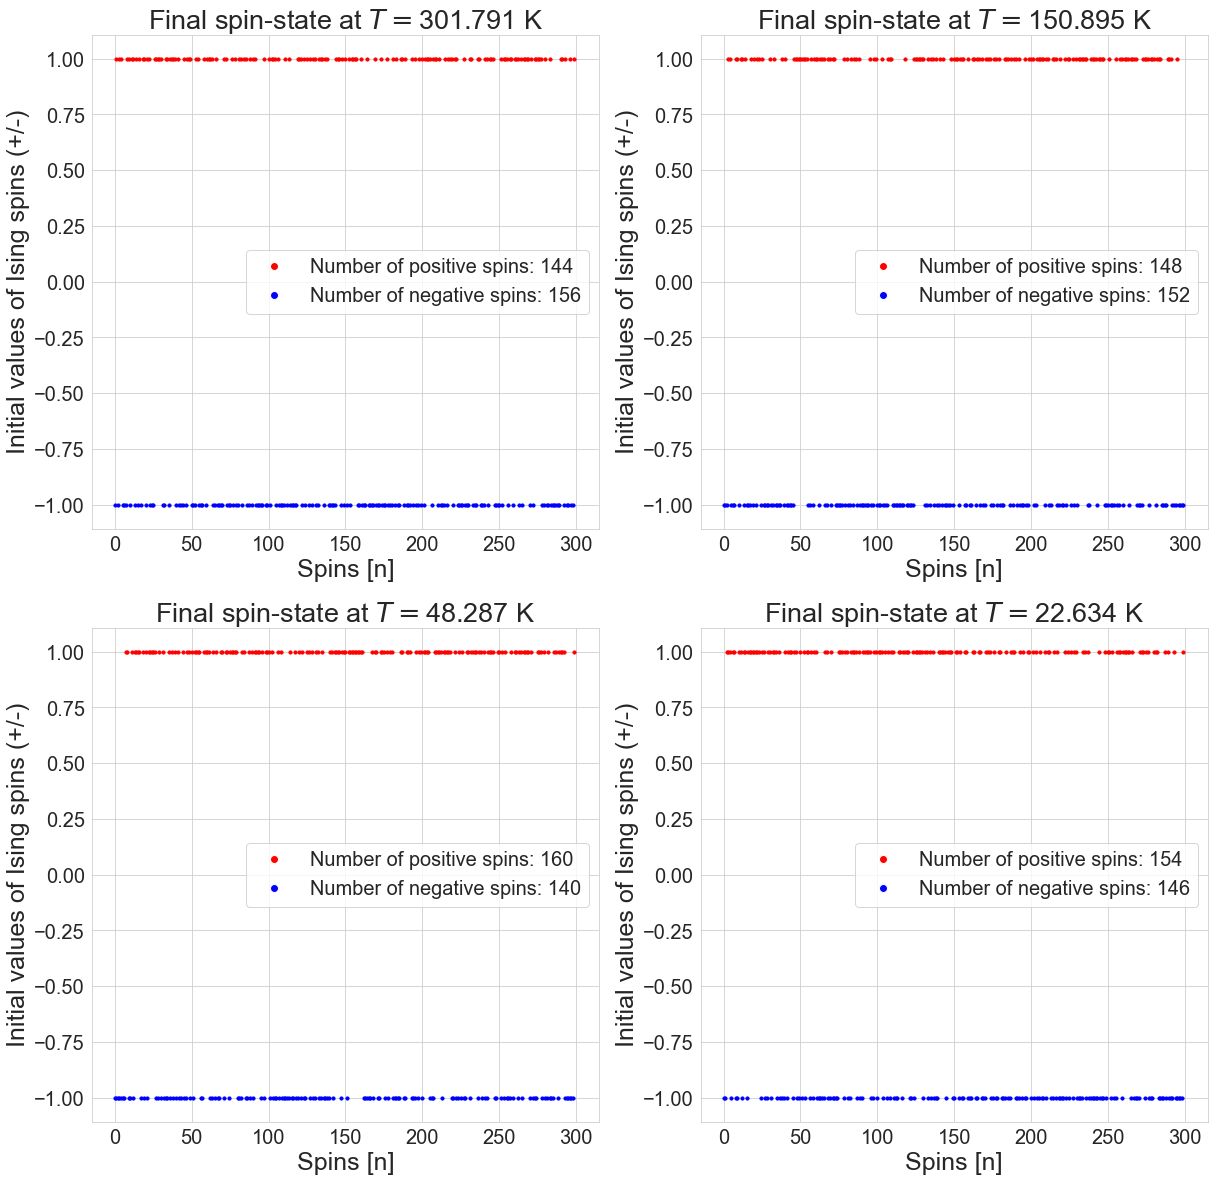

In [81]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20))

titlesize = 27
scattersize = 10
axislabelsize = 25
axisticksize = 20
markersize = 8
legendsize = 20

count = 0
for j in range(0, nrows):
    for k in range(0, ncols):
        # The current positions of the spins
        Spins_positive_1D = Spins_1D_dict[str(j*ncols + k + 1)][Spins_1D_dict[str(j*ncols + k + 1)]>0]
        Spins_negative_1D = Spins_1D_dict[str(j*ncols + k + 1)][Spins_1D_dict[str(j*ncols + k + 1)]<0]

        for i in range(0, N_spin_1D):
            if(Spins_1D_dict[str(j*ncols + k + 1)][i] > 0):
                axes[j][k].scatter(i, Spins_1D_dict[str(j*ncols + k + 1)][i], color='red', s=scattersize)

            elif(Spins_1D_dict[str(j*ncols + k + 1)][i] < 0):
                axes[j][k].scatter(i, Spins_1D_dict[str(j*ncols + k + 1)][i], color='blue', s=scattersize)

        axes[j][k].set_title('Final spin-state at $T =${0:.3f} K'.format(1 / (betas[str(j*ncols + k + 1)] * k_B)),
                             fontsize=titlesize)
                
        axes[j][k].set_xlabel('Spins [n]', fontsize=axislabelsize)
        axes[j][k].set_ylabel('Initial values of Ising spins (+/-)', fontsize=axislabelsize)
        axes[j][k].tick_params(axis='both', which='major', labelsize=axisticksize)

        legend_elements = [Line2D([0], [0], marker='o', color='white',markerfacecolor='red',
                                  markersize=markersize, label='Number of positive spins: {0}'.format(len(Spins_positive_1D))),
                           Line2D([0], [0], marker='o', color='white', markerfacecolor='blue',
                                  markersize=markersize, label='Number of negative spins: {0}'.format(len(Spins_negative_1D)))]

        axes[j][k].legend(handles=legend_elements , loc='center right', fontsize=legendsize)

plt.savefig(image_path +
            'spin_states_1D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Energy propagation of the system

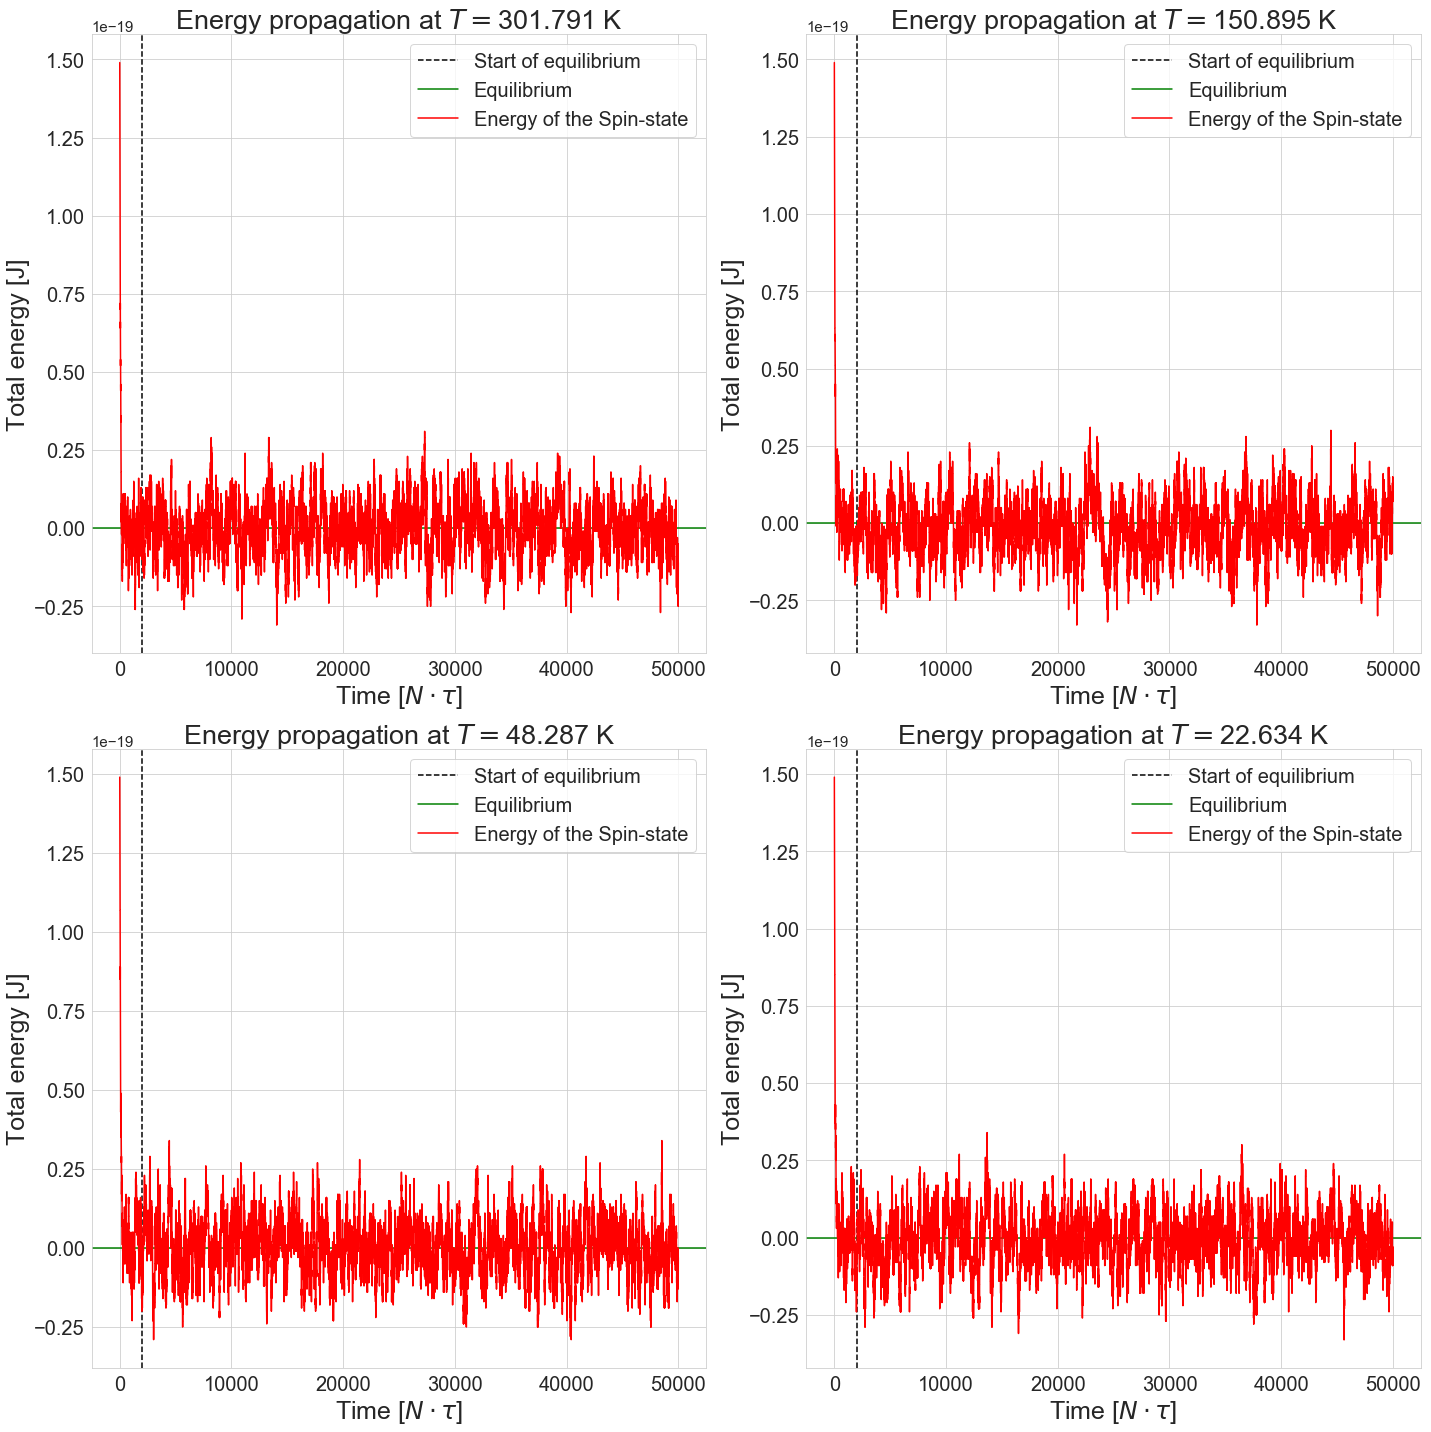

In [82]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_1D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, energy_chronology_1D[str(i*ncols + j + 1)], c='red', label='Energy of the Spin-state')

        axes[i][j].set_title('Energy propagation at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)), fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Total energy [J]', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'discrete_energies_1D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Magnetization of the system
### 1./a Time evolution of magnetization

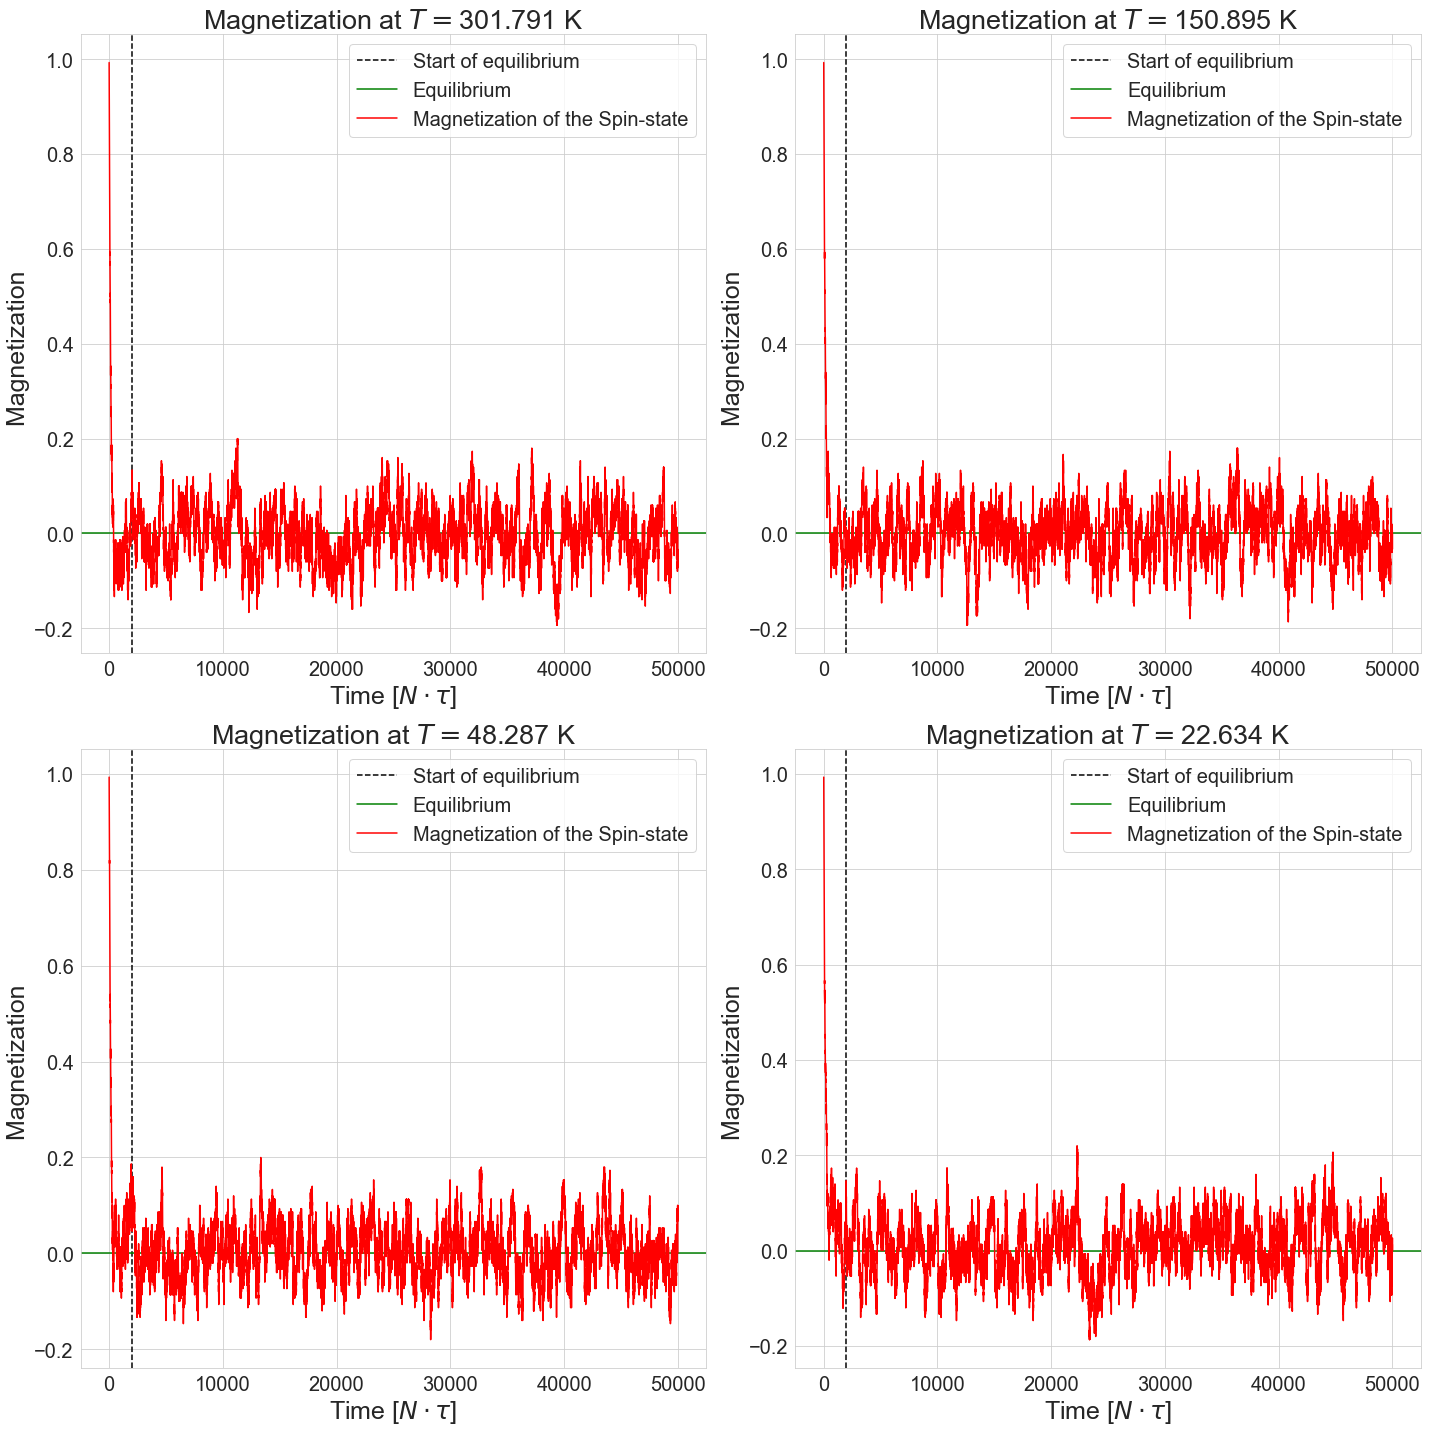

In [83]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_1D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, total_magnetization_1D[str(i*ncols + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)), fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization ', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_1D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./b Zoomed on fluctuations of magnetization

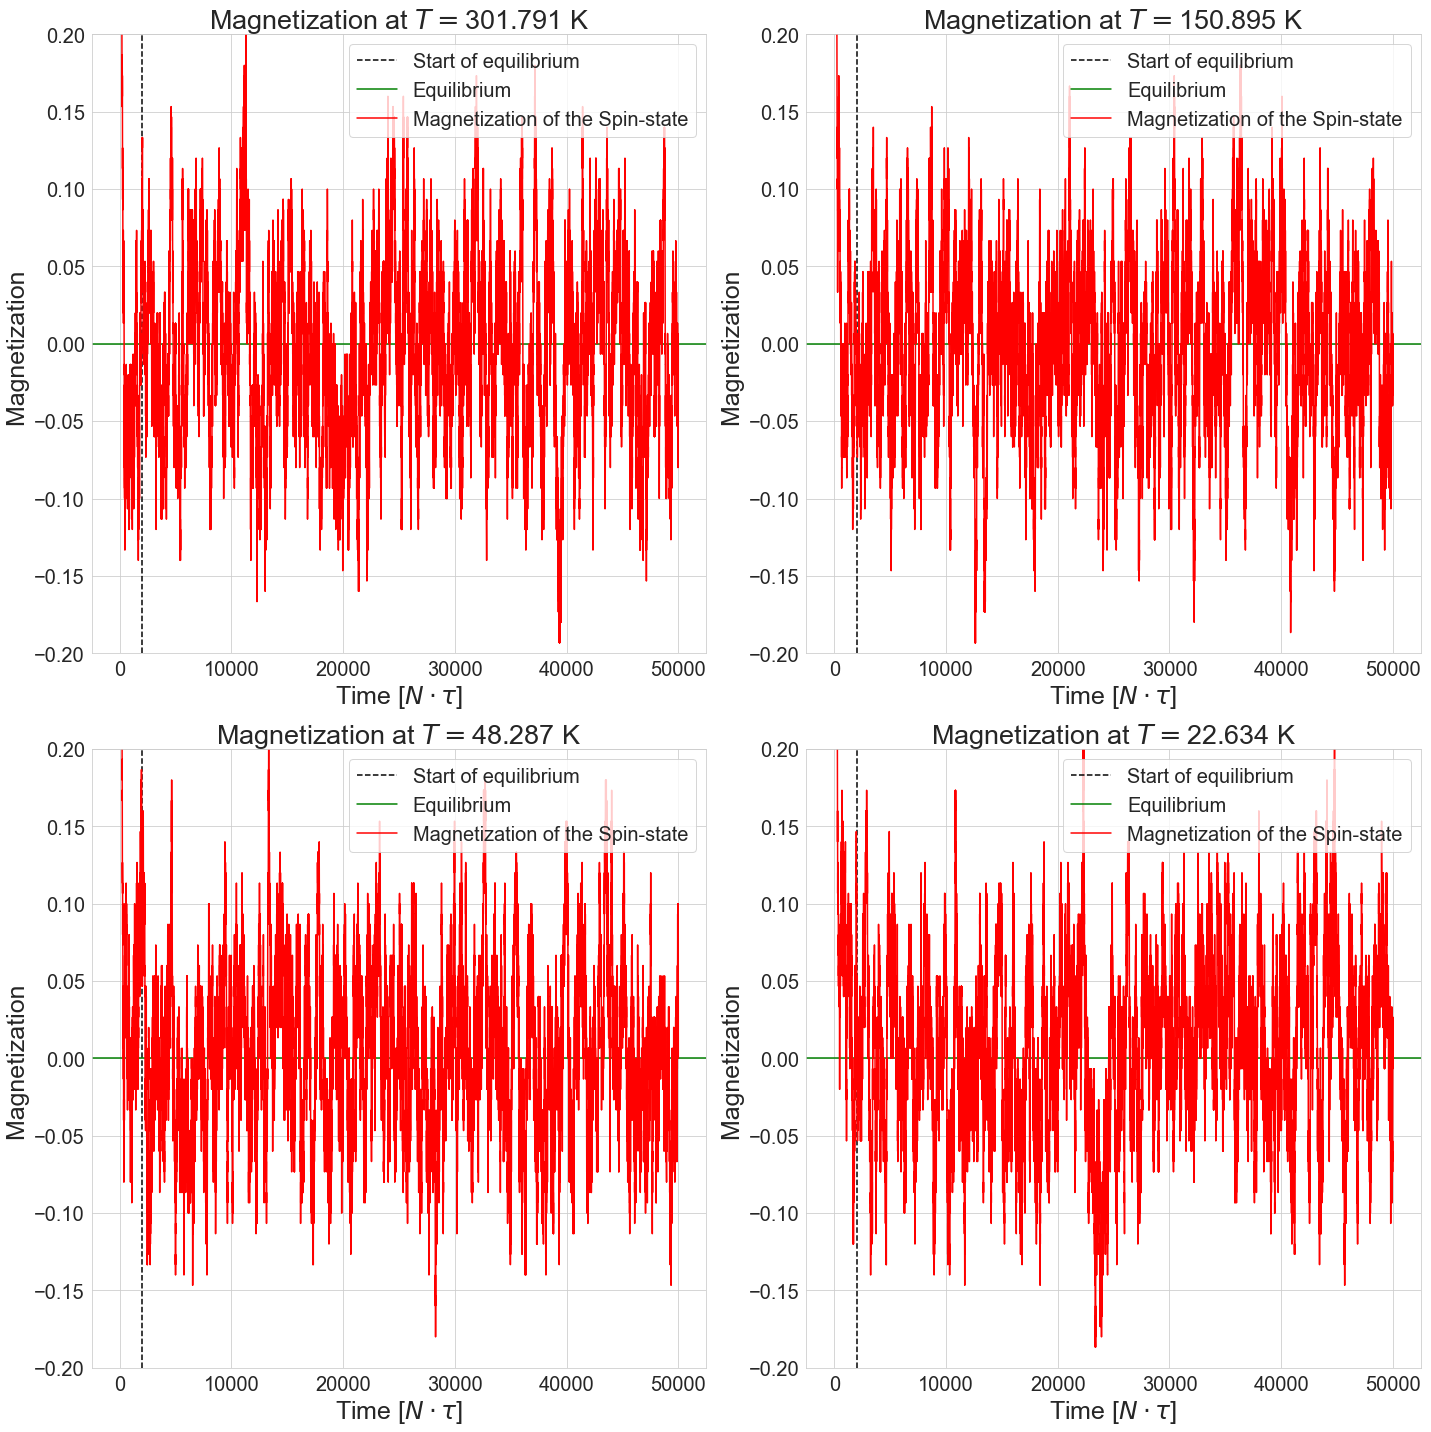

In [84]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_1D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, total_magnetization_1D[str(i*ncols + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)), fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization ', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.2, top=0.2)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_1D_zoomed.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./c Calculating $<m>$ expected value

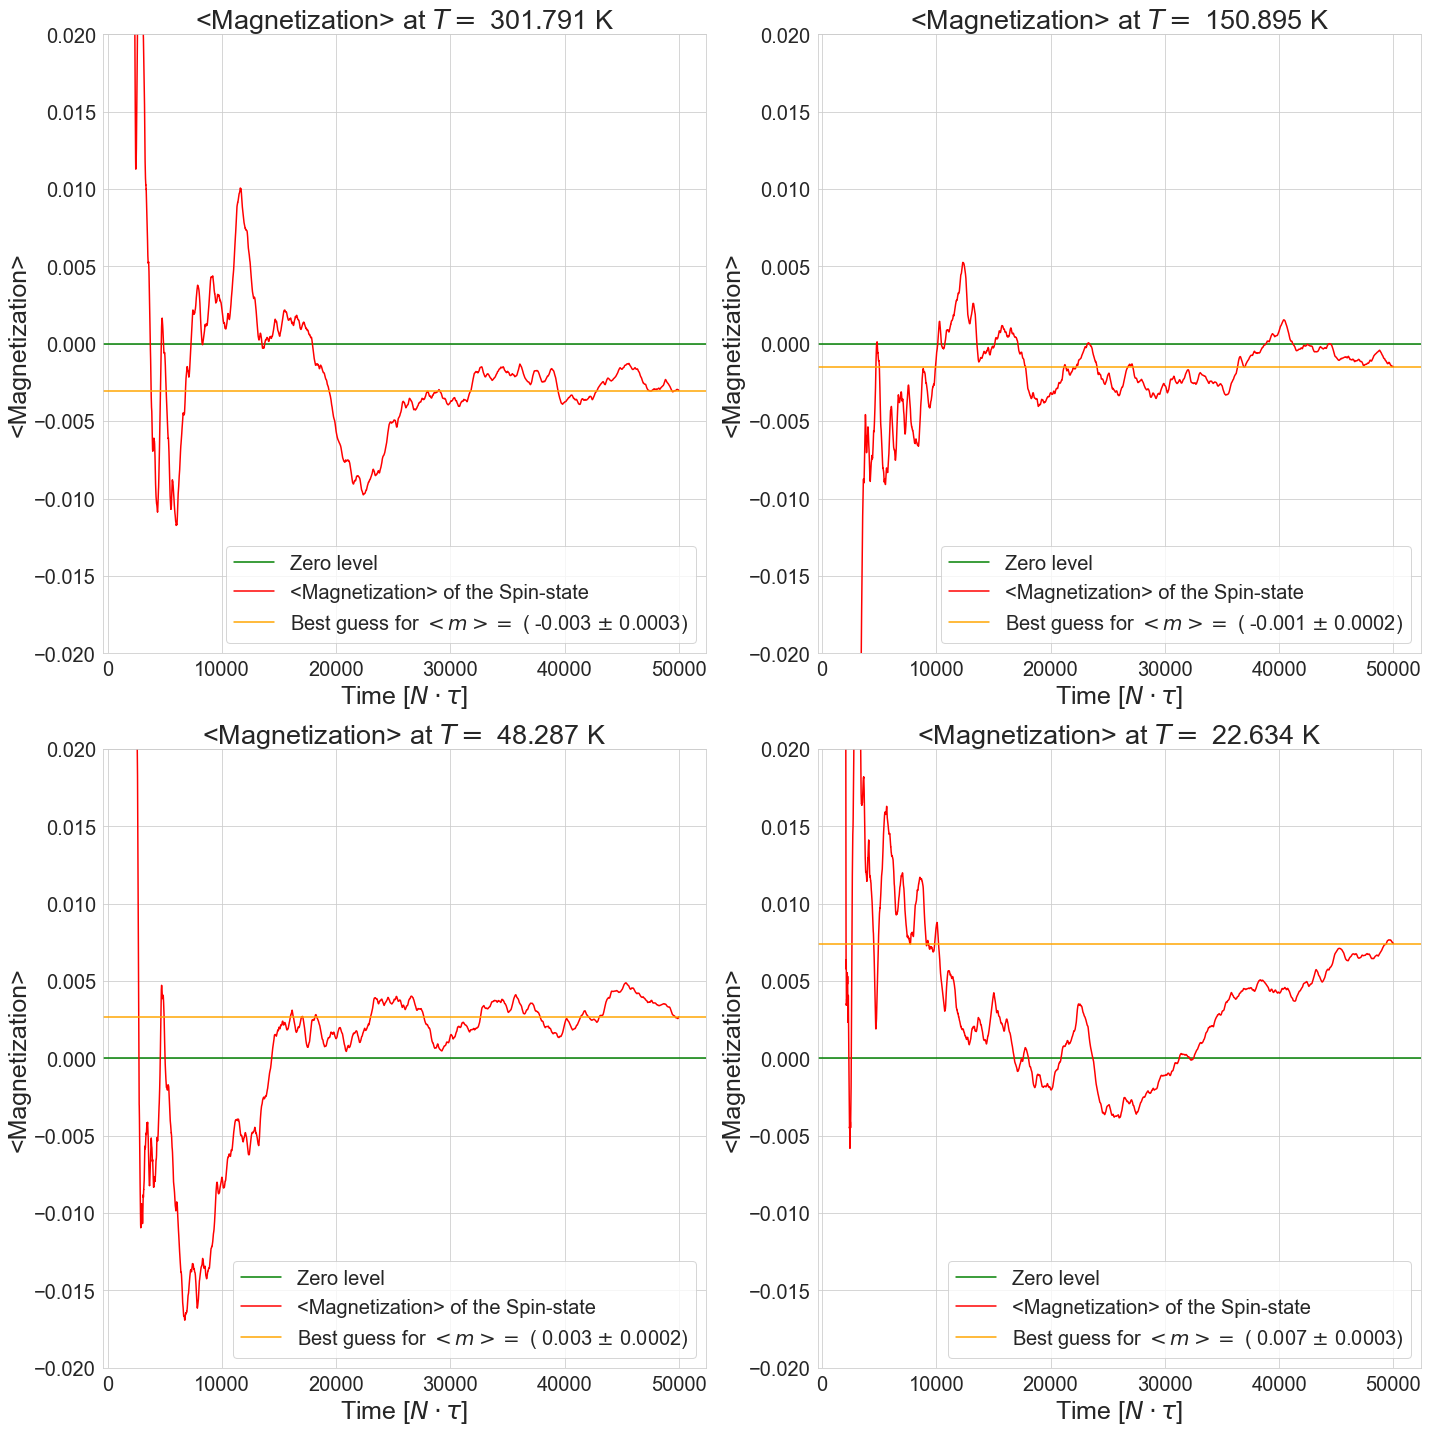

In [85]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_mean_1D = [total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:k].mean()
                                 for k in range(start_offset_1D + 1, steps_1D+1)]

        standard_error_1D = (np.std(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:])/
                             np.sqrt(len(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:])))
        
        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_1D[start_offset_1D + 1:], magnetization_mean_1D, c='red', label='<Magnetization> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_mean_1D[-1], label='Best guess for $<m> =$ ( {0:.3f} $\pm$ {1:.4f})'.format(magnetization_mean_1D[-1],
                                                                                                                       standard_error_1D),
                           color='orange')

        axes[i][j].set_title('<Magnetization> at $T =$ {0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.02, top=0.02)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='lower right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_mean_1D_off' + str(start_offset_1D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Square of magnetization of the system
### 2./a Time evolution of the square of magnetization

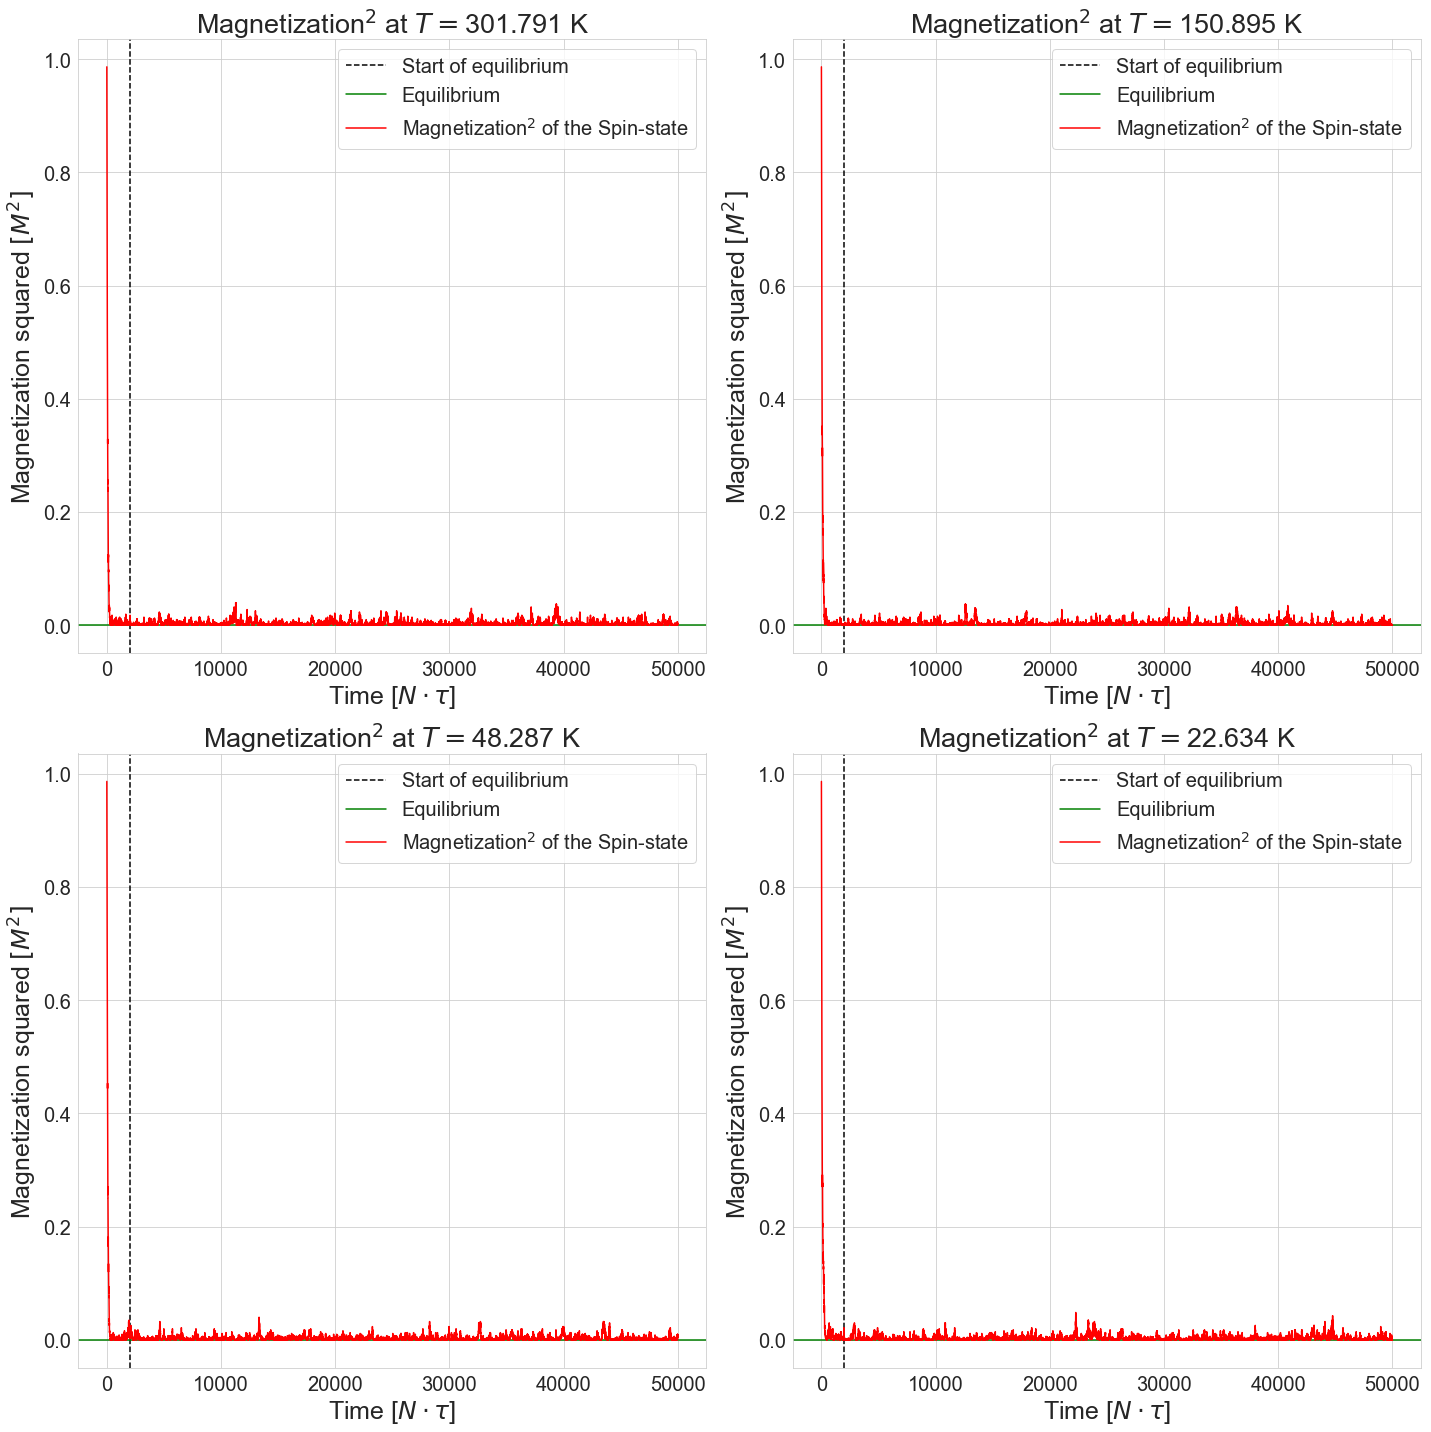

In [86]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_1D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, total_magnetization_1D[str(i*ncols + j + 1)]**2, c='red', label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_1D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./b Zoomed on fluctuations of the square of magnetization

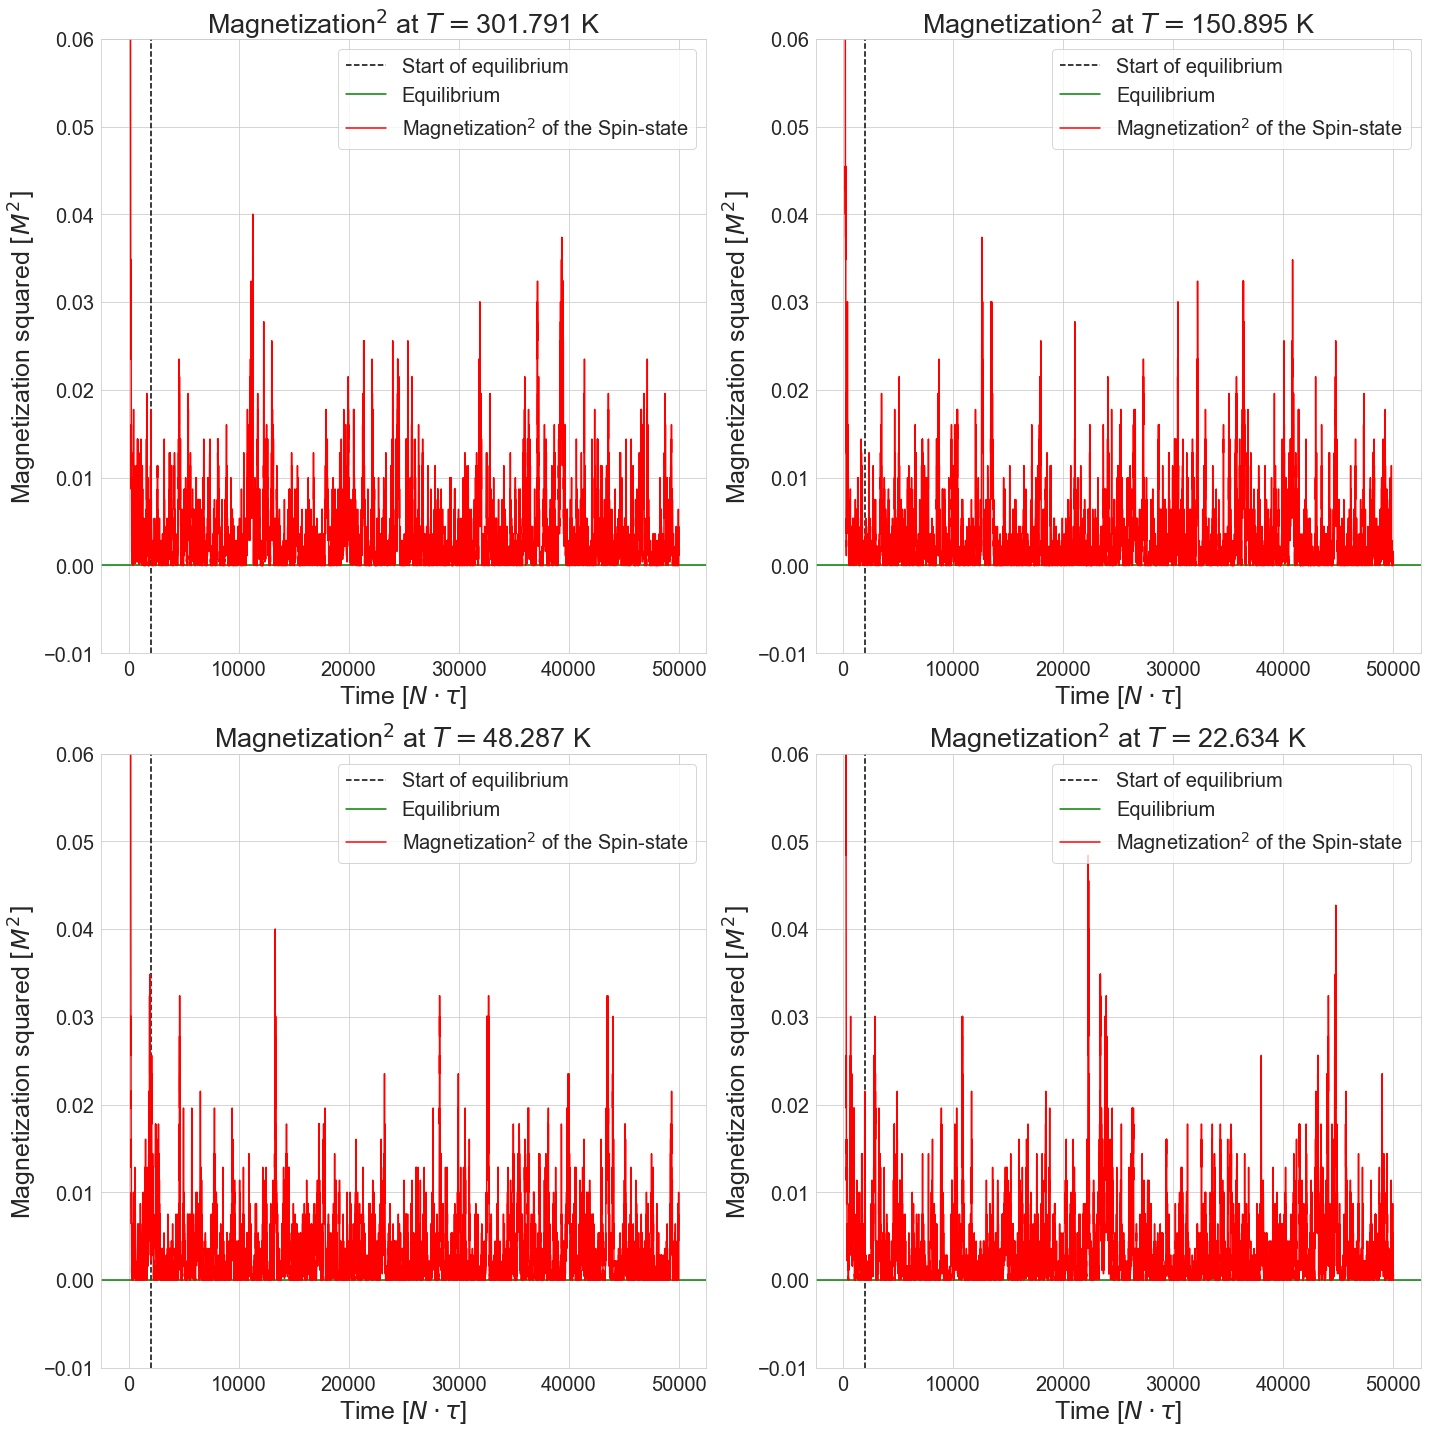

In [87]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_1D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_1D, total_magnetization_1D[str(i*ncols + j + 1)]**2, c='red', label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)

        axes[i][j].set_ylim(bottom=-0.01, top=0.06)
        
        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_1D_zoomed.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./c Calculating $<m^{2}>$ expected value

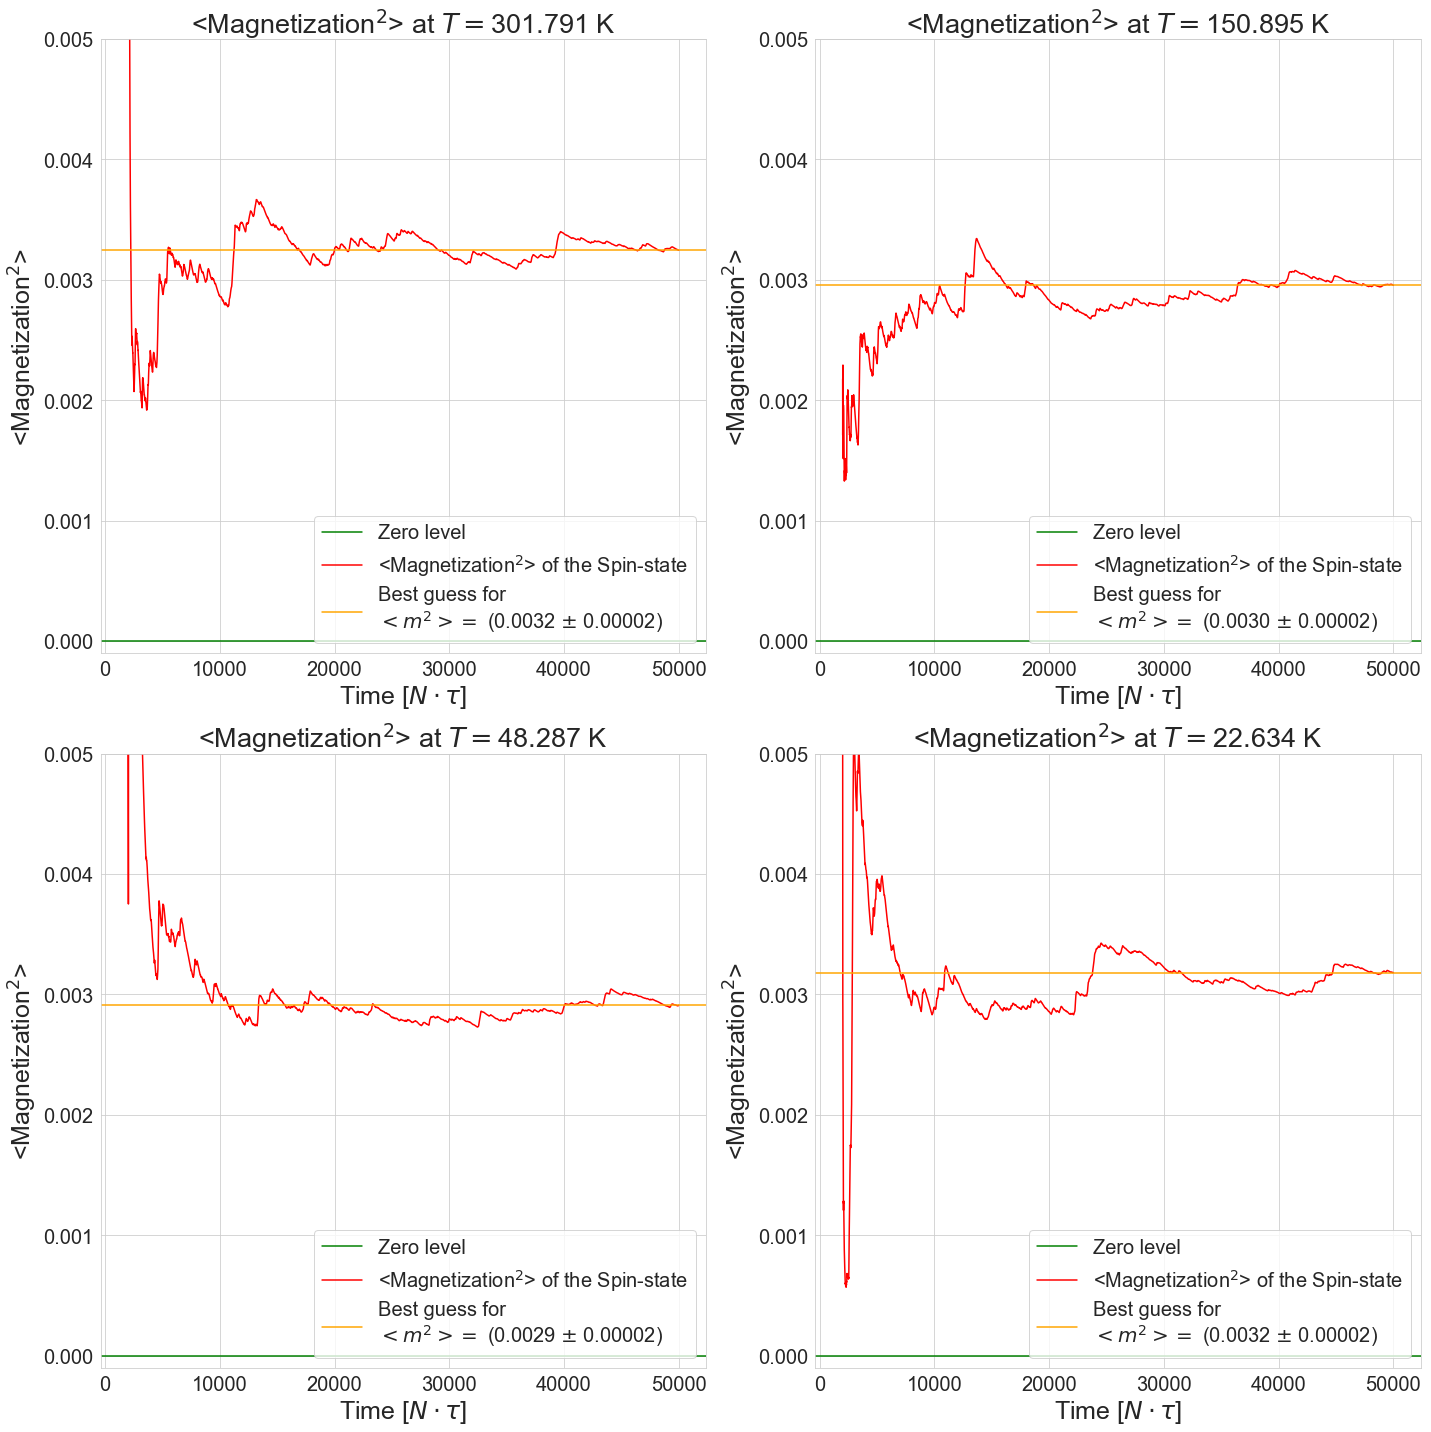

In [88]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_squared_mean_1D = [(total_magnetization_1D[str(i*ncols + j + 1)]**2)[start_offset_1D:k].mean()
                                         for k in range(start_offset_1D + 1, steps_1D+1)]
        
        standard_error_squared_1D = (np.std(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:]**2)/
                                     np.sqrt(len(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:]**2)))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_1D[start_offset_1D + 1:], magnetization_squared_mean_1D, color='red',
                        label='<Magnetization$^{2}$> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_squared_mean_1D[-1], label='Best guess for\n$<m^2> =$ ({0:.4f} $\pm$ {1:.5f})'.format(magnetization_squared_mean_1D[-1],
                                                                                                                                 standard_error_squared_1D),
                           color='orange')

        axes[i][j].set_title('<Magnetization$^2$> at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.0001, top=0.005)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='lower right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_mean_1D_off' + str(start_offset_1D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Calculating $<m^{2}> - <m>^{2} = \sigma^{2}$ variance

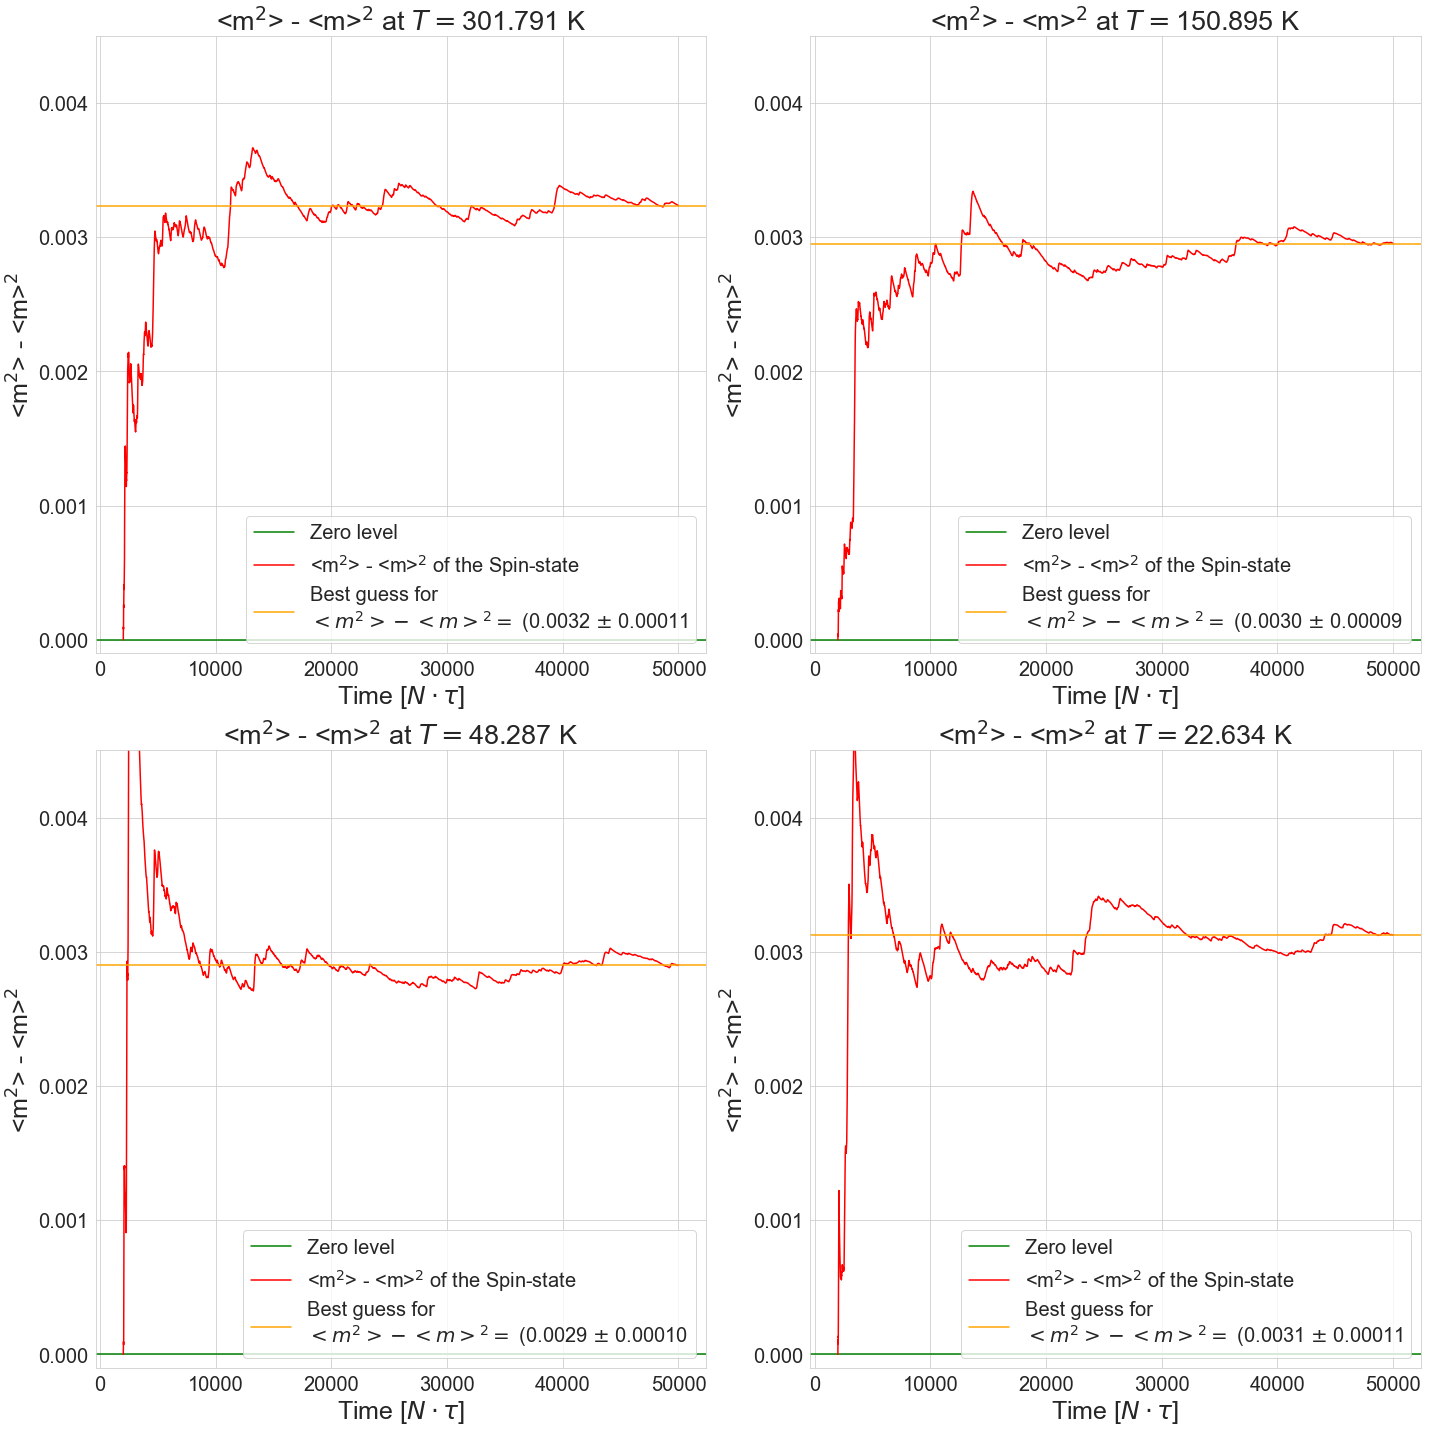

In [89]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_diff_mean_1D = [(total_magnetization_1D[str(i*ncols + j + 1)]**2)[start_offset_1D:k].mean() -
                                       total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:k].mean()**2
                                       for k in range(start_offset_1D + 1, steps_1D+1)]
        
        standard_error_squared_1D = (np.std(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:]**2)/
                                     np.sqrt(len(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:]**2)))
        
        standard_error_1D = (np.std(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:])/
                             np.sqrt(len(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:])))
        
        standard_error_1D = 2 * standard_error_1D * np.max(total_magnetization_1D[str(i*ncols + j + 1)][start_offset_1D:])

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_1D[start_offset_1D + 1:], magnetization_diff_mean_1D, c='red',
                        label='<m$^2$> - <m>$^2$ of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_diff_mean_1D[-1], label='Best guess for\n$<m^2> - <m>^2 =$ ({0:.4f} $\pm$ {1:.5f}'.format(magnetization_diff_mean_1D[-1],
                                                                                                                                     np.sqrt(standard_error_squared_1D**2 + standard_error_1D**2)),
                           color='orange')

        axes[i][j].set_title('<m$^2$> - <m>$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*ncols + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<m$^2$> - <m>$^2$', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.0001, top=0.0045)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='lower right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_diff_mean_1D_off' + str(start_offset_1D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Fitting magnetizations
Testing theoretical model if mean magnetization is exponentially decreasing over time
> Only works if offset_1D = 0 !!

In [18]:
def fit_func(N, A, B, C):
    return A * np.e ** (B * N) + C

In [19]:
def value_prep(current_magnetization):
    
    # N = inf: exp(B * N(inf)) = 0
    # A * 0 + C = C
    # Calculate 'C'
    C = current_magnetization[-1]

    # N = 0: exp(B * N(0)) = 1
    # A * 1 + C = A + C
    # Calculate 'A'
    A = current_magnetization[0] - C
    
    # y = A * np.e ** (B * N) + C
    # B = ln((y - C) / A) / N
    # Calculate 'B'
    B = np.log((np.array(current_magnetization[5000:5000+50]).mean() - C) / A) / ((5000 + 5000 + 50)/2)
    
    print("Characteristic time:", (-1/B))
    
    return A, B, C

### Calculating $<m>$ expected value

In [20]:
if(start_offset_1D == 0):
    p0_fit_1D = {}
    x_fit_1D = {}
    y_fit_1D = {}
    popt_1D = {}
    pcov_1D = {}
    perr_1D = {}

    for i in range(0, len(betas)):
        magnetization_mean_1D = [total_magnetization_1D[str(i+1)][:k].mean()
                                 for k in range(1, steps_1D+1)]
        p0_fit_1D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_1D)

        x_fit_1D[str(i+1)] = step_indeces_1D[1:]
        y_fit_1D[str(i+1)] = magnetization_mean_1D
        popt_1D[str(i+1)], pcov_1D[str(i+1)] = curve_fit(fit_func,
                                                         x_fit_1D[str(i+1)],
                                                         y_fit_1D[str(i+1)],
                                                         p0=p0_fit_1D[str(i+1)])

        perr_1D[str(i+1)] = np.sqrt(np.diag(pcov_1D[str(i+1)]))

In [21]:
if(start_offset_1D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_mean_1D = [(total_magnetization_1D[str(i*ncols + j + 1)])[:k].mean()
                                     for k in range(1, steps_1D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_1D[1:], magnetization_mean_1D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_1D[1:], fit_func(x_fit_1D[str(i*ncols + j + 1)], *popt_1D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_fitted_1D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [22]:
if(start_offset_1D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_1D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_1D[str(i+1)][2]))

### Calculating $<m^{2}>$ expected value

In [23]:
if(start_offset_1D == 0):
    p0_fit_square_1D = {}
    x_fit_square_1D = {}
    y_fit_square_1D = {}
    popt_square_1D = {}
    pcov_square_1D = {}
    perr_square_1D = {}

    offset_square_1D = 8000

    for i in range(0, len(betas)):
        magnetization_mean_1D = [(total_magnetization_1D[str(i+1)]**2)[:k].mean()
                                 for k in range(1, steps_1D+1)]
        p0_fit_square_1D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_1D)

        x_fit_square_1D[str(i+1)] = step_indeces_1D[1:]
        y_fit_square_1D[str(i+1)] = magnetization_squared_mean_1D
        popt_square_1D[str(i+1)], pcov_square_1D[str(i+1)] = curve_fit(fit_func,
                                                                       x_fit_square_1D[str(i+1)],
                                                                       y_fit_square_1D[str(i+1)],
                                                                       p0=p0_fit_square_1D[str(i+1)])

        perr_square_1D[str(i+1)] = np.sqrt(np.diag(pcov_square_1D[str(i+1)]))

In [24]:
if(start_offset_1D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_squared_mean_1D = [(total_magnetization_1D[str(i*ncols + j + 1)]**2)[:k].mean()
                                             for k in range(1, steps_1D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_1D[1:], magnetization_squared_mean_1D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_1D[1:], fit_func(x_fit_square_1D[str(i*ncols + j + 1)], *popt_square_1D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_squared_fitted_1D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [25]:
if(start_offset_1D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_square_1D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m^2> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_square_1D[str(i+1)][2]))

# Ising model simulation on 2D lattice

In [26]:
start_offset_2D = 2000

## 1.: Randomly choose directions for starting position of the spins

In [27]:
def choose_sign_2D():
    return -1 if random.random() < 0.5 else 1

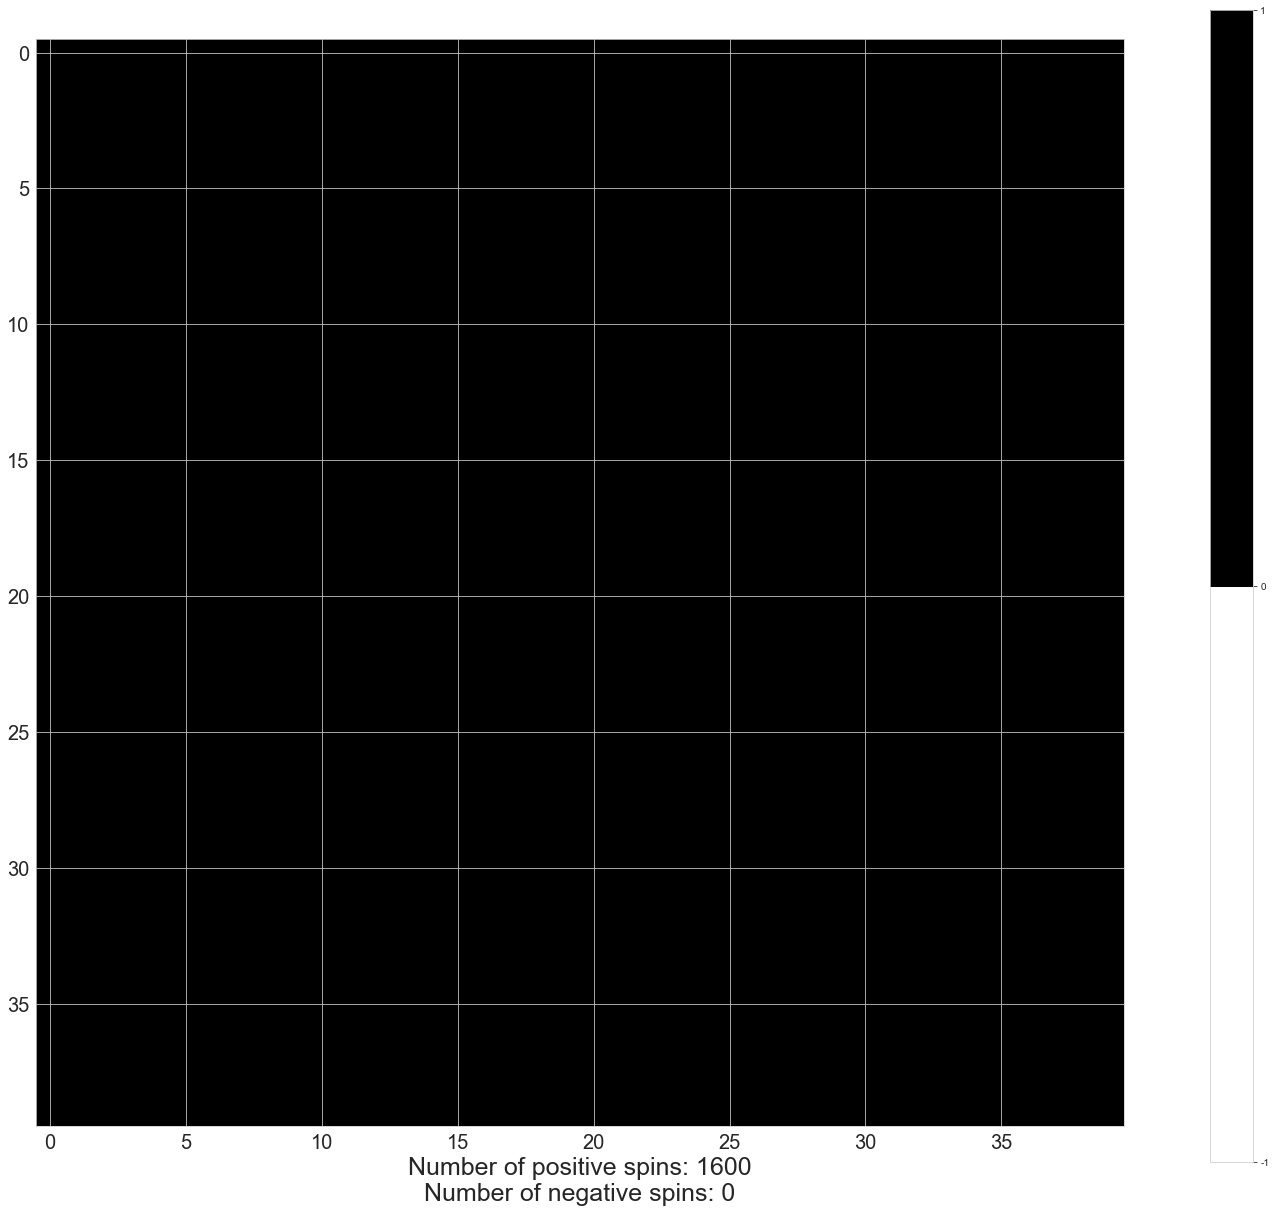

In [28]:
# The current positions of the spins
#Spins_2D = np.array(([[choose_sign() for i in range(0, N_spin_2D)] for i in range(0, N_spin_2D)]))
Spins_2D = np.ones((N_spin_2D, N_spin_2D))
Spins_positive_2D = Spins_2D[Spins_2D>0]
Spins_negative_2D = Spins_2D[Spins_2D<0]

nrows = 1
ncols = 1
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

spin_image = axes.imshow(Spins_2D, cmap='Greys_r')

axes.set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                      len(Spins_negative_2D)),
                fontsize=axislabelsize)
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.show()

## 2.1.: $E_{tot.}$ energy of the current state

In [32]:
def E_Initial_2D(Spins):
    
    E = 0
    
    for i in range(0, N_spin_2D-2):
        for j in range(0, N_spin_2D-2):
            
            try:
                E += Spins[i][j] * Spins[i+1][j] + Spins[i][j] * Spins[i][j+1] + Spins[i][j] * Spins[i+1][j+1]
            except:
                pass
            else:
                continue
    
    return E * J

## 2.2.: $\Delta E$ energy change due to spin-flip

In [33]:
def dE_2D(Spins, indeces):
    
    E = 0
    
    for i in range(-1, 2):
        for j in range(-1, 2):
            if(i != 0 and j != 0):
                try:
                    E += 2 * Spins[indeces[0]][indeces[1]] * Spins[indeces[0]+i][indeces[1]+j]
                except:
                    pass
                else:
                    continue
                    
    return E * J

## 3.: Step with the simulation

In [34]:
def simulation_step_2D(beta, steps, Spins_2D):

    Spins = Spins_2D
    # Chronologies for reached energy levels' indeces and actual energies in order
    spin_changes_chronology = np.zeros((steps+1, N_spin_2D, N_spin_2D), dtype='int')
    energy_chronology = np.zeros((steps+1))
    total_magnetization = np.zeros((steps+1))
    
    # Starting position on X axis
    spin_changes_chronology[0] = Spins
    energy_chronology[0] = E_Initial_2D(Spins=Spins)
    total_magnetization[0] = Spins.sum()/len(Spins)

    for current_step in range(0, steps):
        # Choose a random Ising spin from the pool at the start of every step
        choosen_spin_indeces = np.random.choice([i for i in range(0, N_spin_2D)], 2)
        
        # Rotate it to check the energy difference
        New_Spins = Spins
        New_Spins[choosen_spin_indeces[0]][choosen_spin_indeces[1]] *= -1

        # Calculate energy difference between the jump's origin and end points
        E_1 = E_Initial_2D(Spins=Spins)

        E_2 = E_Initial_2D(Spins=New_Spins)
        
        delta_E = E_2 - E_1

        # Update chronology of reached energies indeces
        # If delta_E <= 0, then execute the flip
        if(delta_E < 0):
            spin_changes_chronology[current_step+1] = New_Spins
            Spins = New_Spins
            # Update chronology of actual reached energy levels
            energy_chronology[current_step+1] = E_2
            
        if(delta_E == 0):
            if(random.random() < 0.5):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1

        # If delta_E > 0, choose a random number X, between 0 and 1
        # If X < e^(-beta * delta_E), then execute the spin flip
        # If not, then leave the spins' state untouched and continue with the next step
        else:
            if(random.random() < np.exp(- beta * delta_E)):
                spin_changes_chronology[current_step+1] = New_Spins
                Spins = New_Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_2
                
            else:
                spin_changes_chronology[current_step+1] = Spins
                # Update chronology of actual reached energy levels
                energy_chronology[current_step+1] = E_1
                
        # Update the total magnetization chronology
        total_magnetization[current_step] = Spins.sum()/(len(Spins)**2)

    return spin_changes_chronology, energy_chronology, total_magnetization, Spins

## Run the simulation with initial conditions

In [35]:
steps_2D = 100000

# Dicts for storing the energy levels' indeces and actual energies for various betas
spin_changes_chronology_2D = {}
energy_chronology_2D = {}
total_magnetization_2D = {}
Spins_2D_dict = {}

# Run the simulation
for i in range(0,len(betas)):
    (spin_changes_chronology_2D[str(i+1)],
     energy_chronology_2D[str(i+1)],
     total_magnetization_2D[str(i+1)],
     Spins_2D_dict[str(i+1)]) = simulation_step_2D(beta=betas[str(i+1)],
                                                  steps=steps_2D,
                                                  Spins_2D=Spins_2D.copy())

step_indeces_2D = np.asarray([i for i in range(0, steps_2D+1)])

## Final spin-state

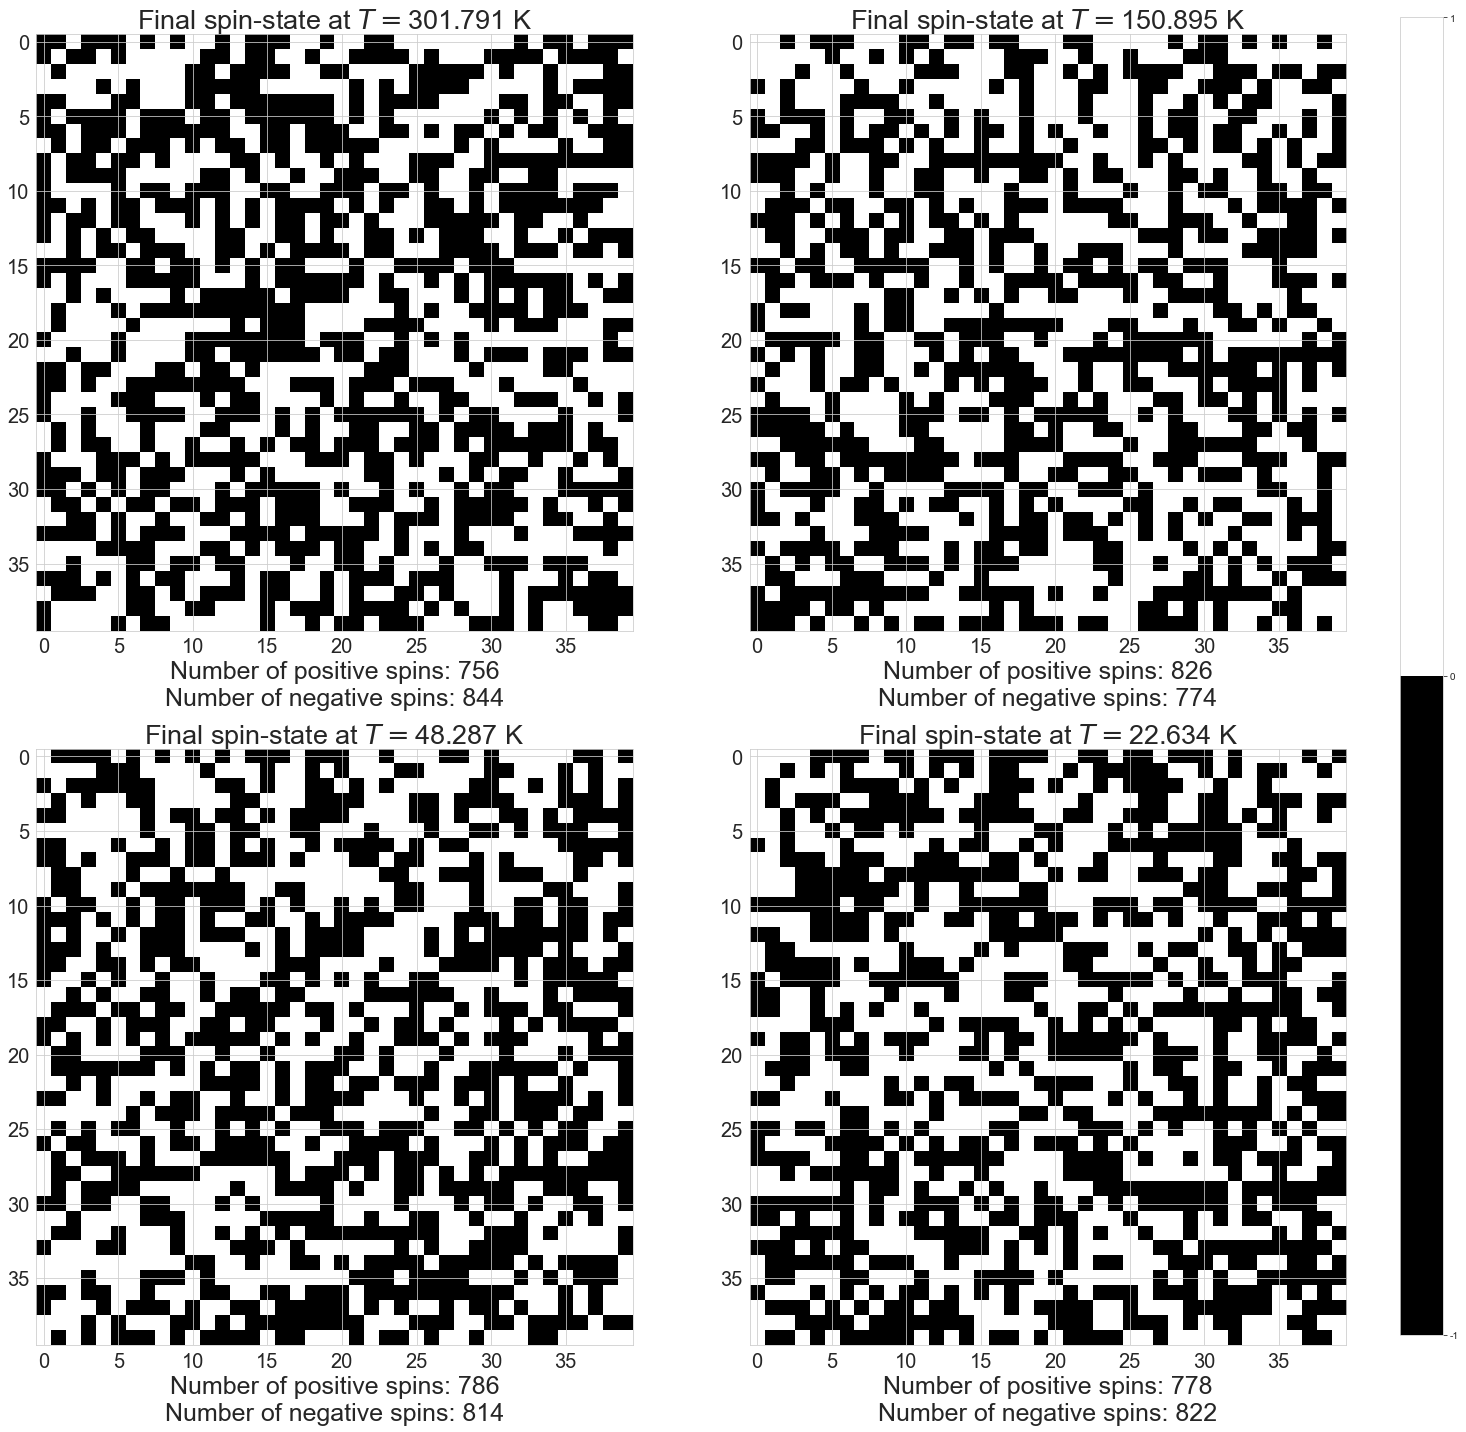

In [36]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0, nrows):
    for j in range(0, ncols):
        
        spin_image = axes[i][j].imshow(Spins_2D_dict[str(i*ncols + j + 1)], cmap='Greys_r')
        
        # The current positions of the spins
        Spins_positive_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]>0]
        Spins_negative_2D = Spins_2D_dict[str(i*ncols + j + 1)][Spins_2D_dict[str(i*nrows + j + 1)]<0]
        
        axes[i][j].set_title('Final spin-state at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)
        
        axes[i][j].set_xlabel('Number of positive spins: {0}\nNumber of negative spins: {1}'.format(len(Spins_positive_2D),
                                                                                                    len(Spins_negative_2D)),
                        fontsize=axislabelsize)
        
        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)

fig.tight_layout()

#
#  CUSTOM COLORBAR
#
cmap = plt.cm.Greys_r  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(-1, 1, 3)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# create a second axes for the colorbar
ax2 = fig.add_axes([1, 0.07, 0.03, 0.915])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
     spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

plt.savefig(image_path +
            'spin_states_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

In [37]:
#np.save('spinstate_2D.npy', spin_changes_chronology_2D['1']);

## Energy propagation of the system

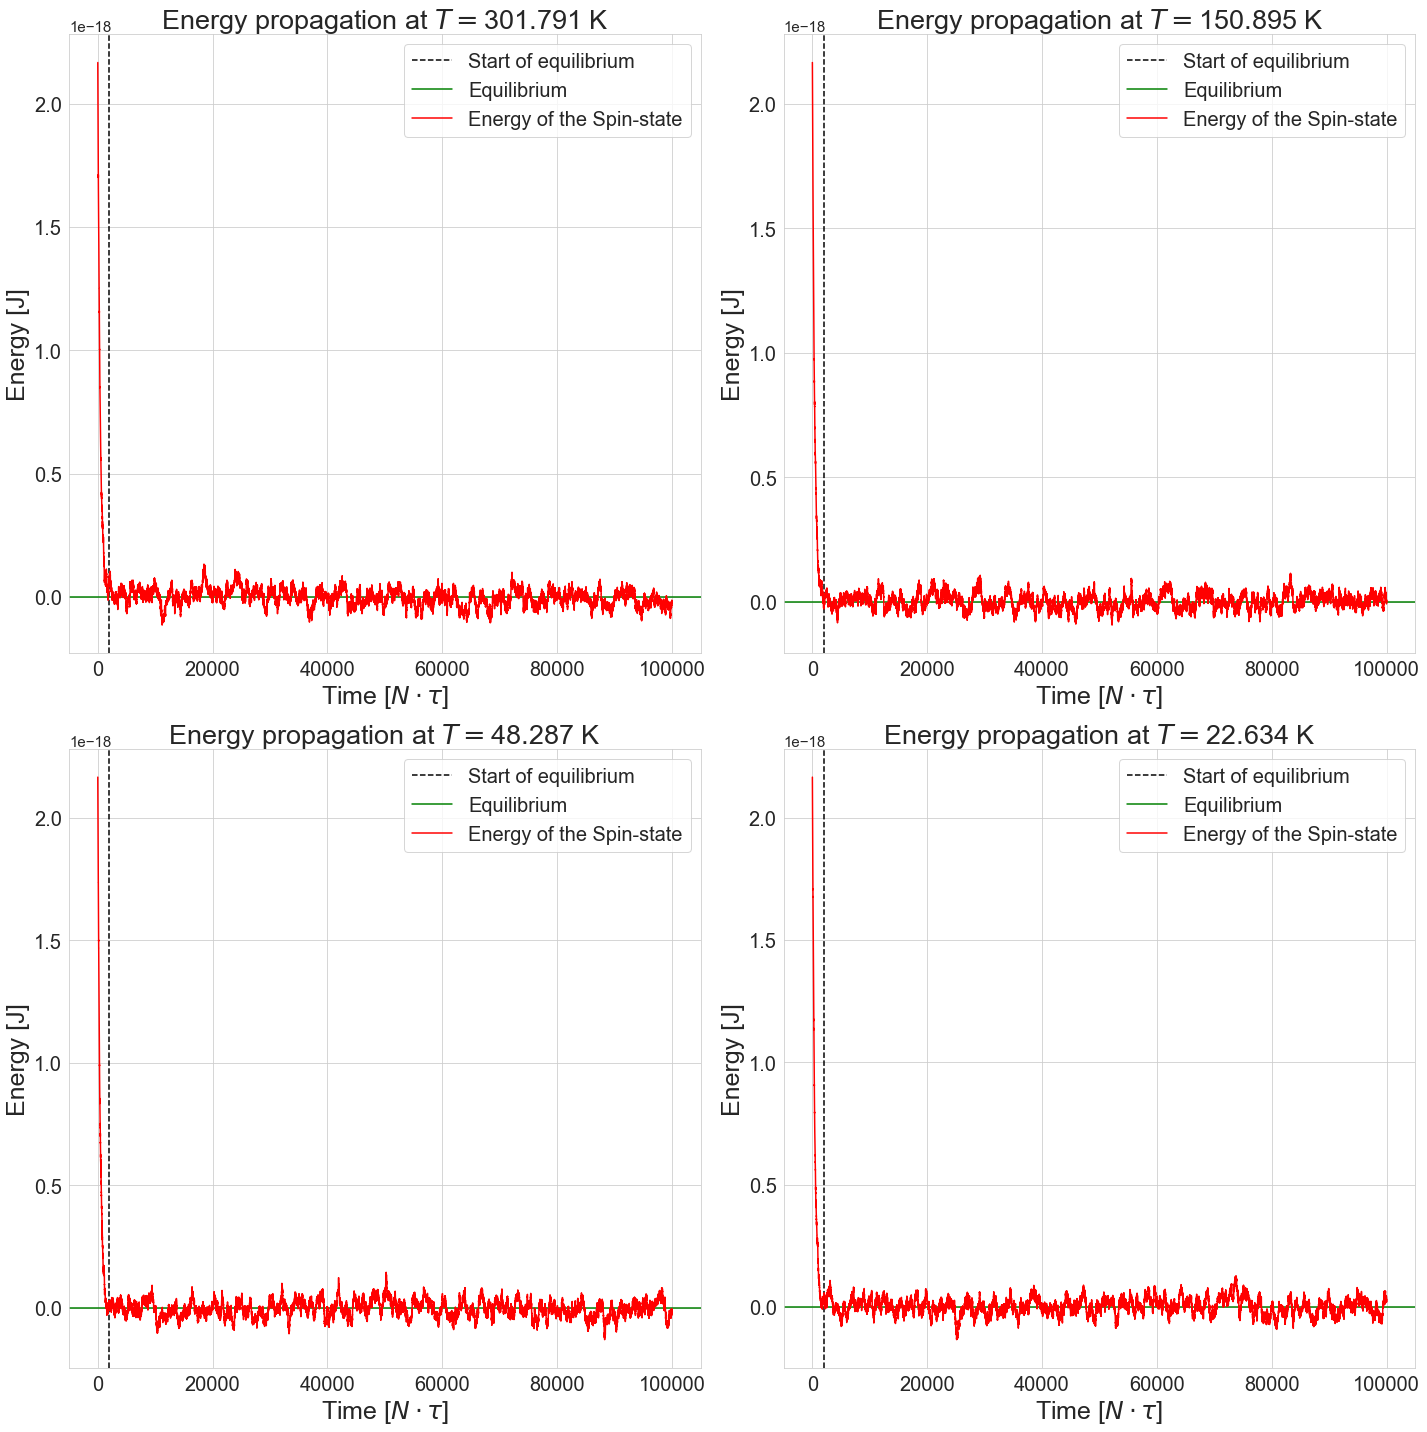

In [38]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, energy_chronology_2D[str(i*nrows + j + 1)], c='red', label='Energy of the Spin-state')

        axes[i][j].set_title('Energy propagation at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Energy [J]', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'discrete_energies_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Magnetization of the system
### 1./a Time evolution of magnetization

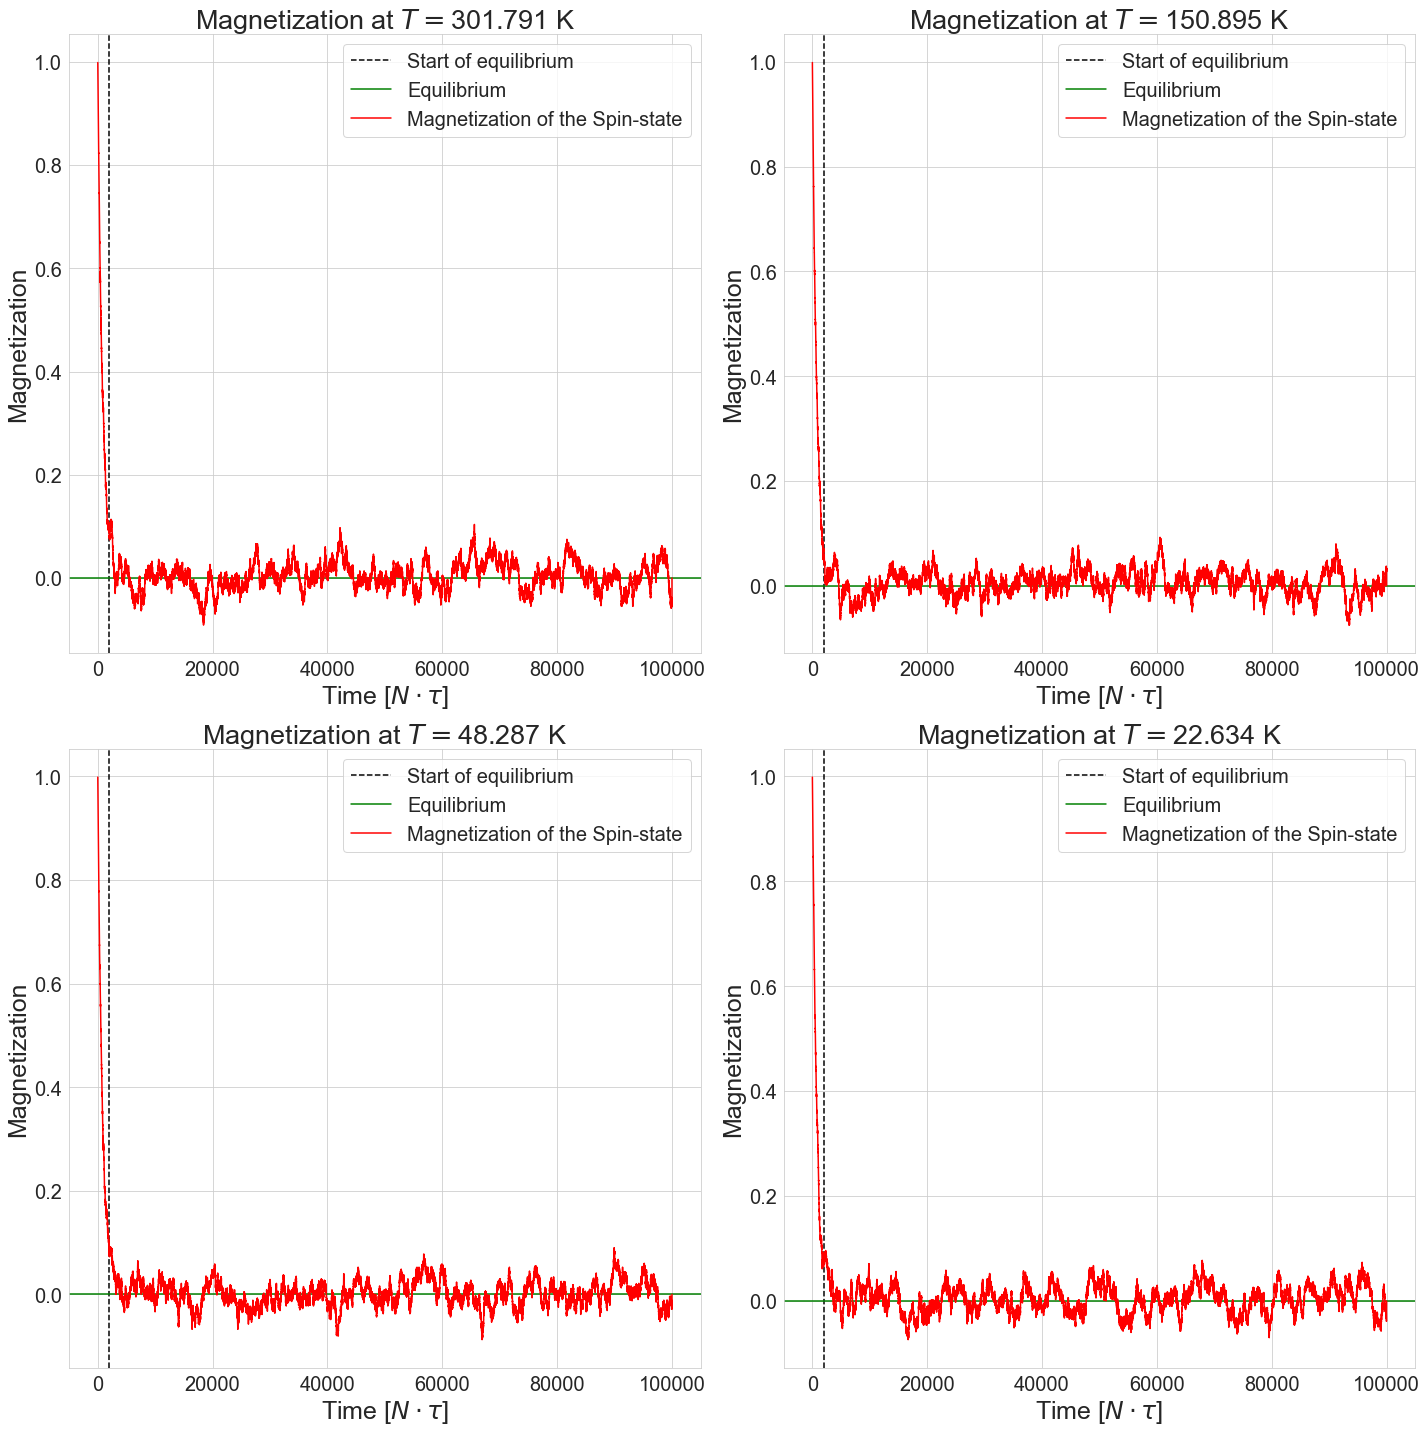

In [39]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./b Zoomed on fluctuations of magnetization

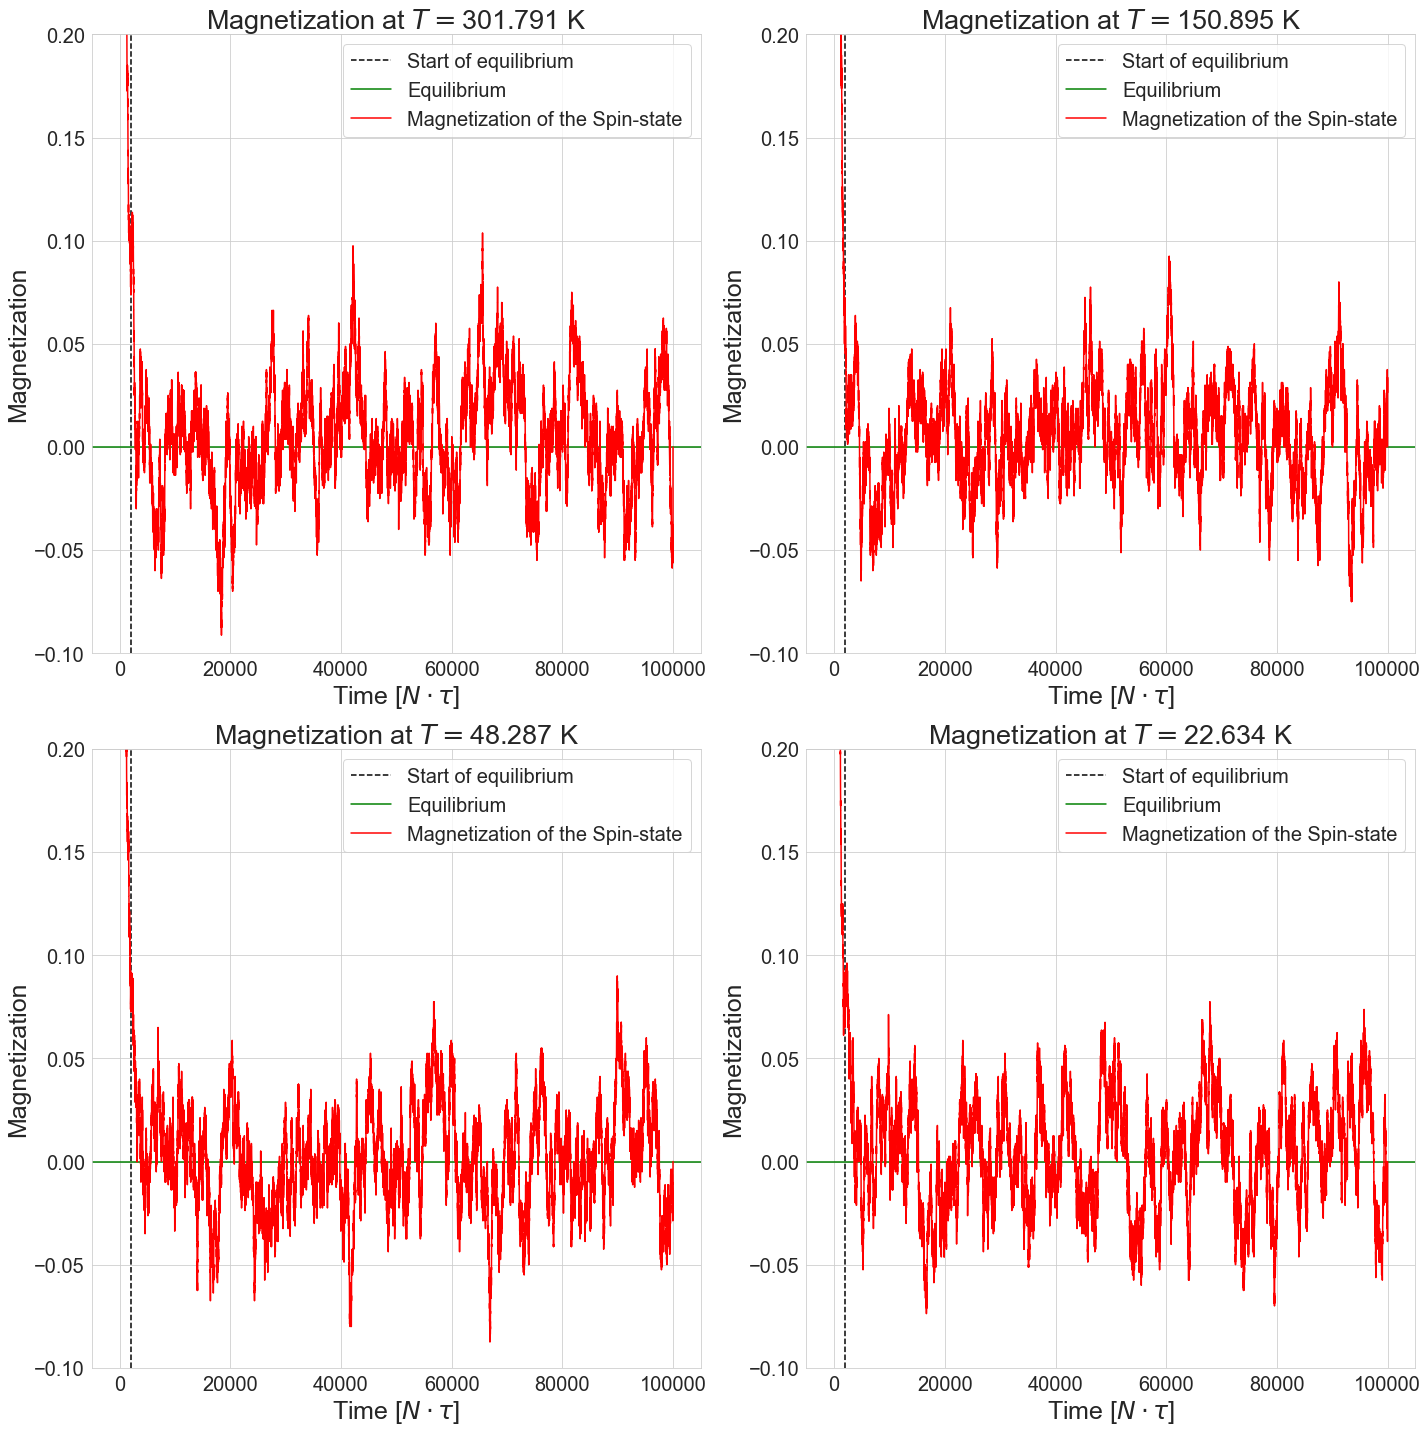

In [40]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)], c='red', label='Magnetization of the Spin-state')

        axes[i][j].set_title('Magnetization at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.1, top=0.2)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 1./c Calculating $<m>$ expected value

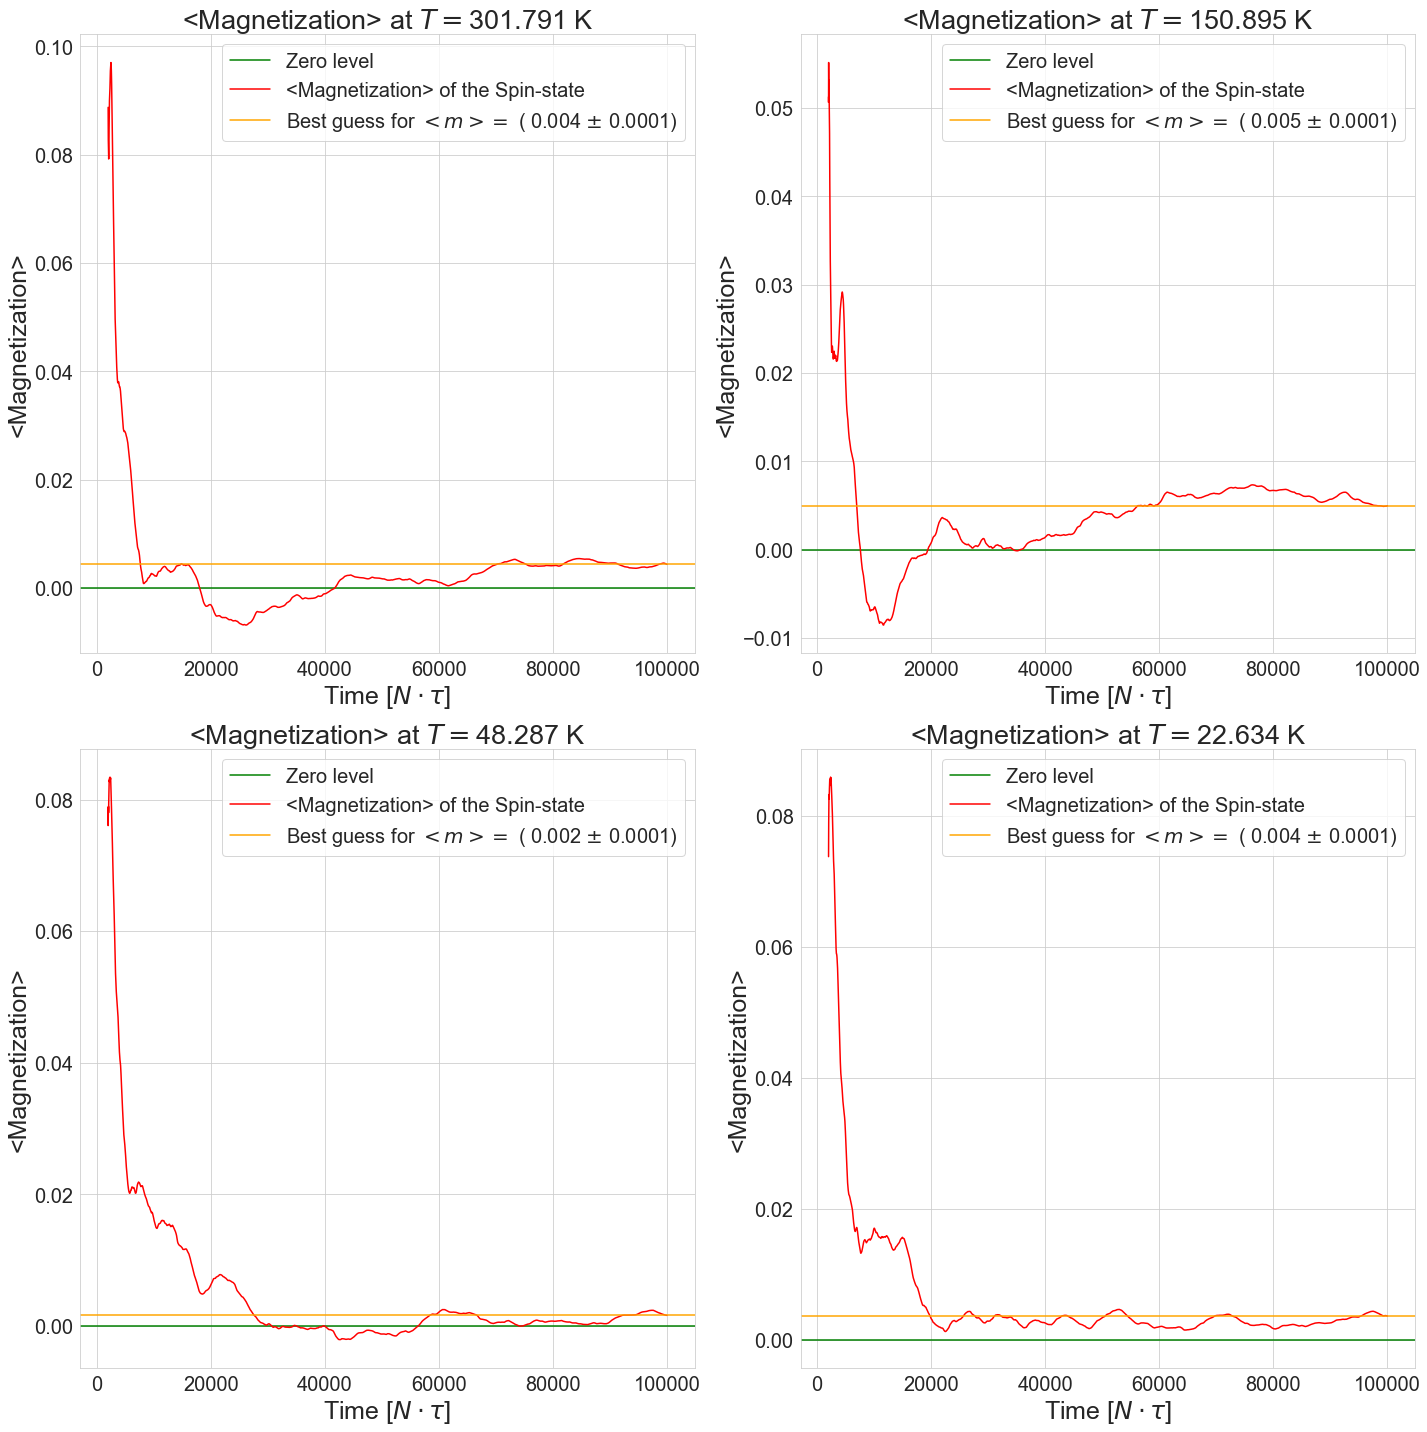

In [48]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_mean_2D = [total_magnetization_2D[str(i*nrows + j + 1)][start_offset_2D:k].mean()
                                 for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])/
                             np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_mean_2D, c='red', label='<Magnetization> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_mean_2D[-1], label='Best guess for $<m> =$ ( {0:.3f} $\pm$ {1:.4f})'.format(magnetization_mean_2D[-1],
                                                                                                                       standard_error_2D),
                           color='orange')

        axes[i][j].set_title('<Magnetization> at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=20)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Square of magnetization of the system
### 2./a Time evolution of the square of magnetization

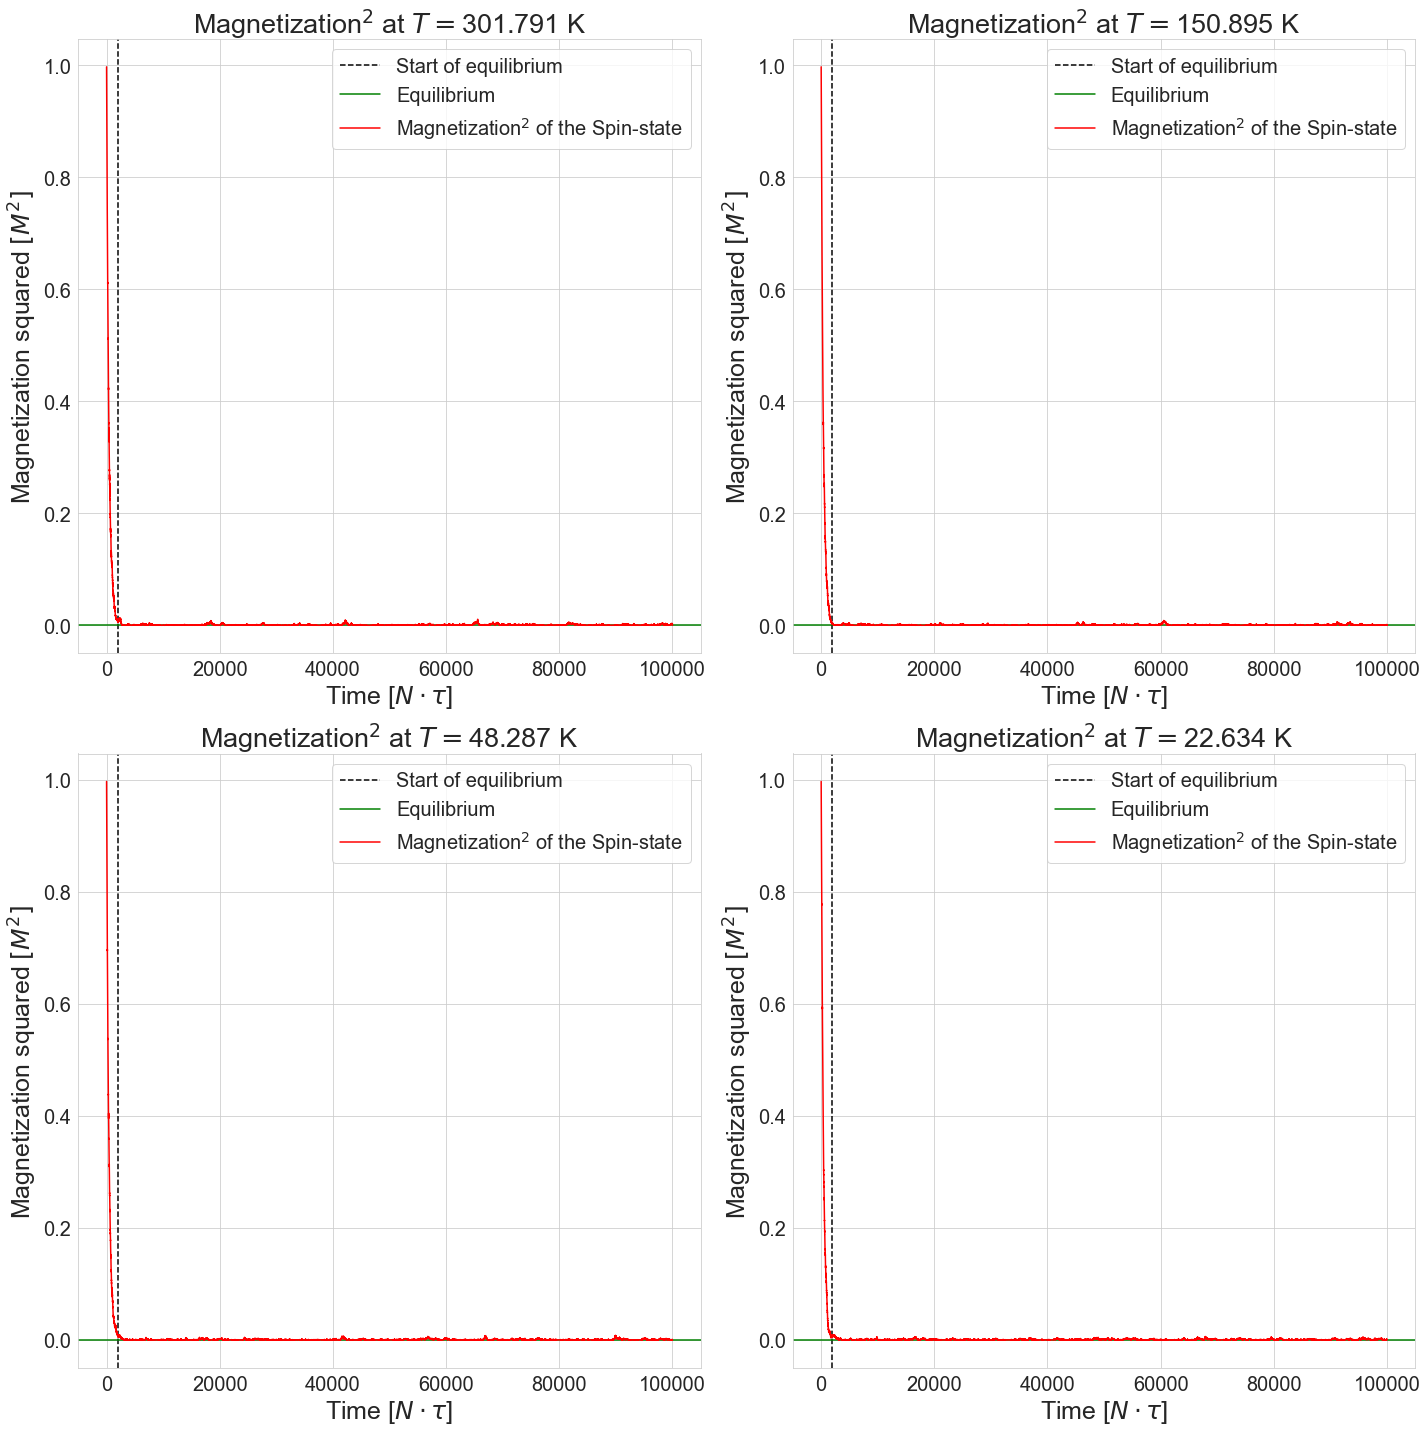

In [42]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)]**2, c='red',
                        label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./b Zoomed on fluctuations of the square of magnetization

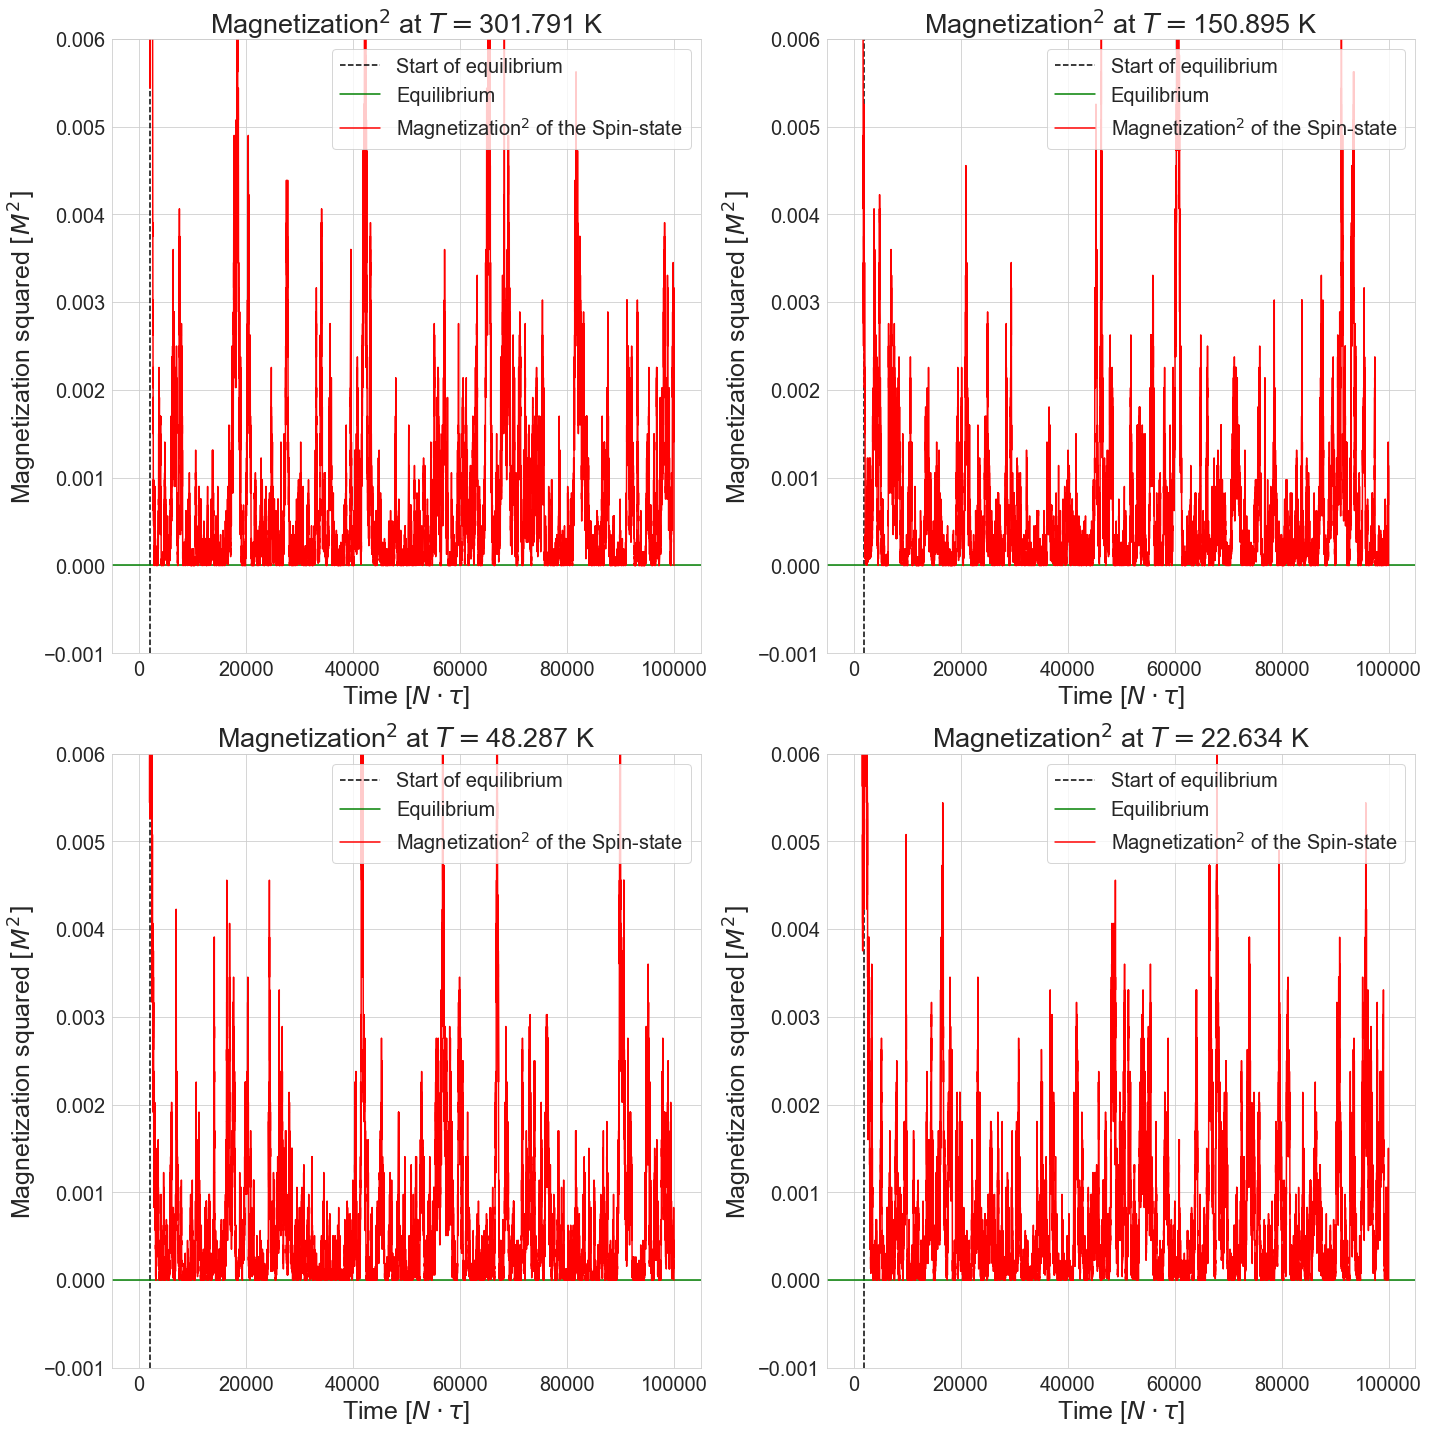

In [43]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):

        axes[i][j].axvline(x=start_offset_2D, color='black', linestyle='--', label='Start of equilibrium')
        axes[i][j].axhline(y=0, color='green', label='Equilibrium')
        axes[i][j].plot(step_indeces_2D, total_magnetization_2D[str(i*nrows + j + 1)]**2, c='red',
                        label='Magnetization$^2$ of the Spin-state')

        axes[i][j].set_title('Magnetization$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('Magnetization squared $\\left[ M^2 \\right]$', fontsize=axislabelsize)
        
        axes[i][j].set_ylim(bottom=-0.001, top=0.006)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_2D.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

### 2./c Calculating $<m^{2}>$ expected value

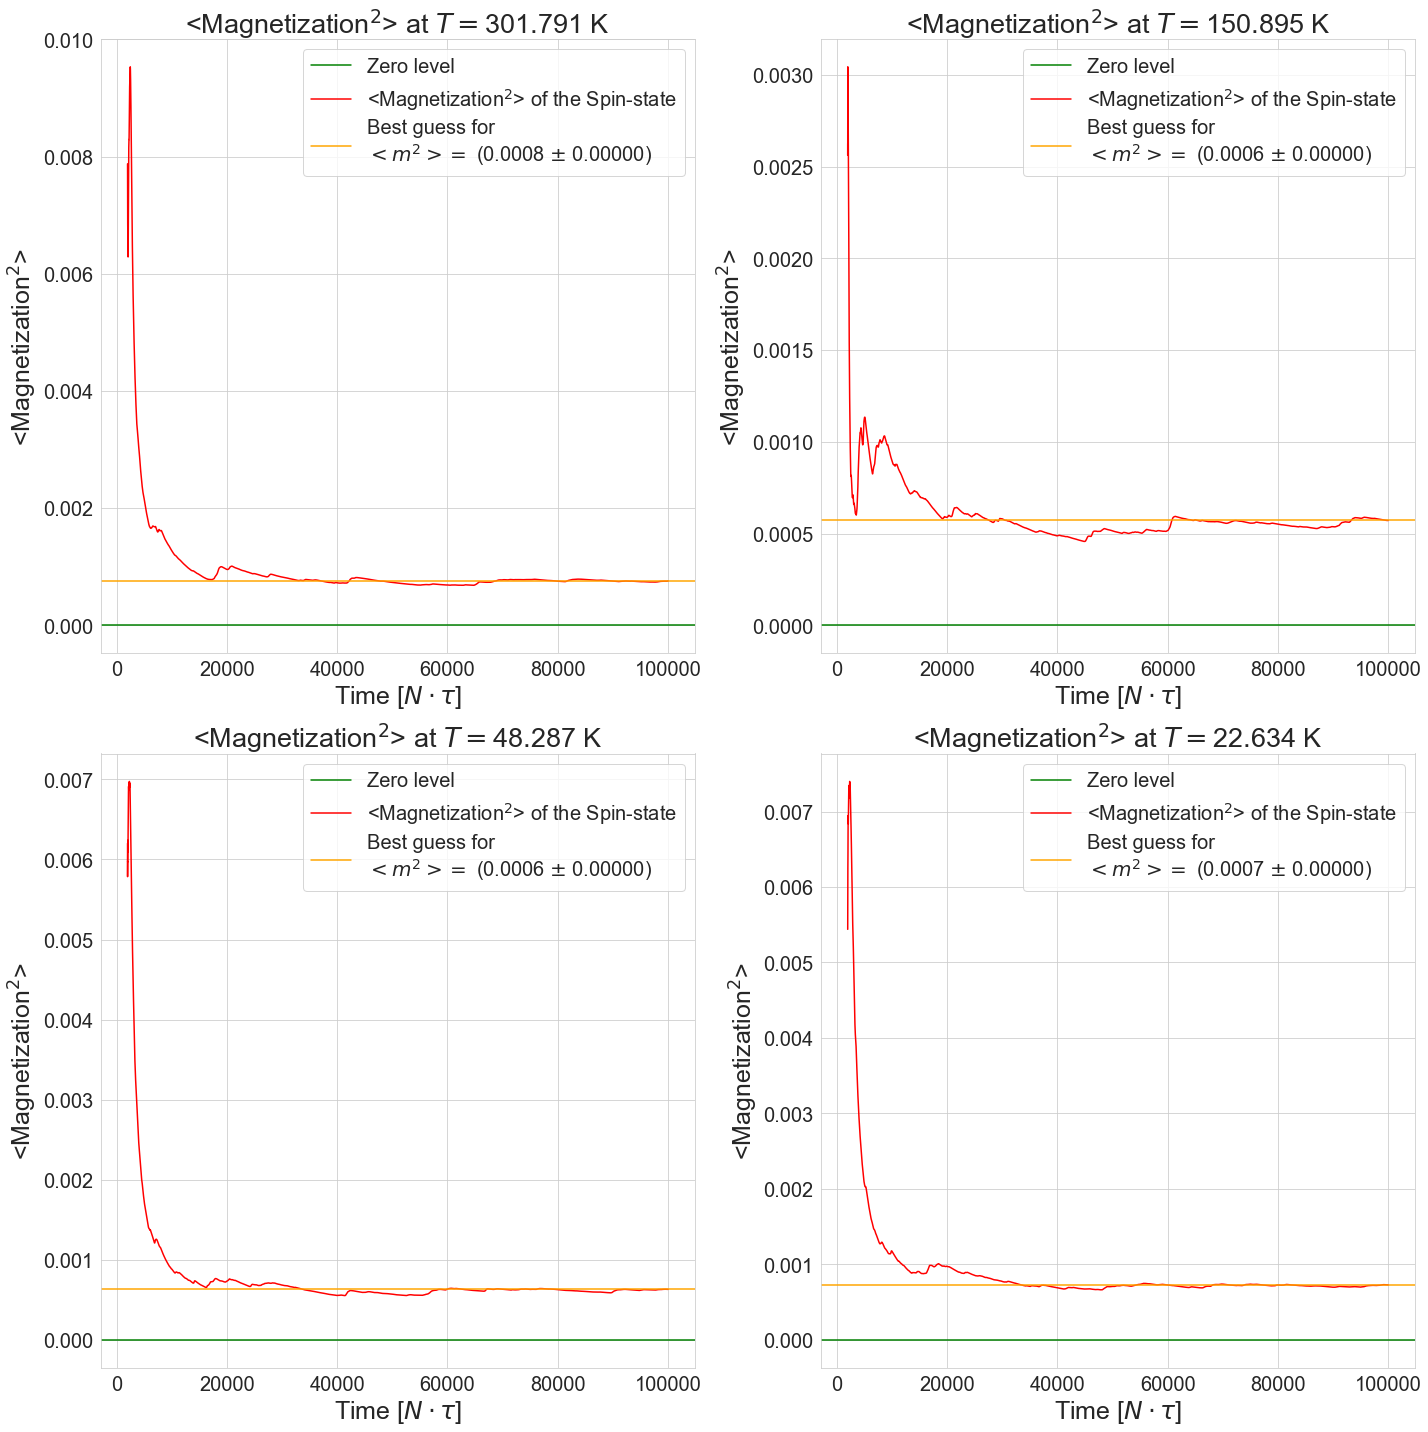

In [47]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_squared_mean_2D = [(total_magnetization_2D[str(i*nrows + j + 1)]**2)[start_offset_2D:k].mean()
                                      for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_squared_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)/
                                     np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_squared_mean_2D, c='red',
                        label='<Magnetization$^{2}$> of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_squared_mean_2D[-1], label='Best guess for\n$<m^2> =$ ({0:.4f} $\pm$ {1:.5f})'.format(magnetization_squared_mean_2D[-1],
                                                                                                                                 standard_error_squared_2D),
                           color='orange')

        axes[i][j].set_title('<Magnetization$^2$> at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='upper right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_squared_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Calculating $<m^{2}> - <m>^{2} = \sigma^{2}$ variance

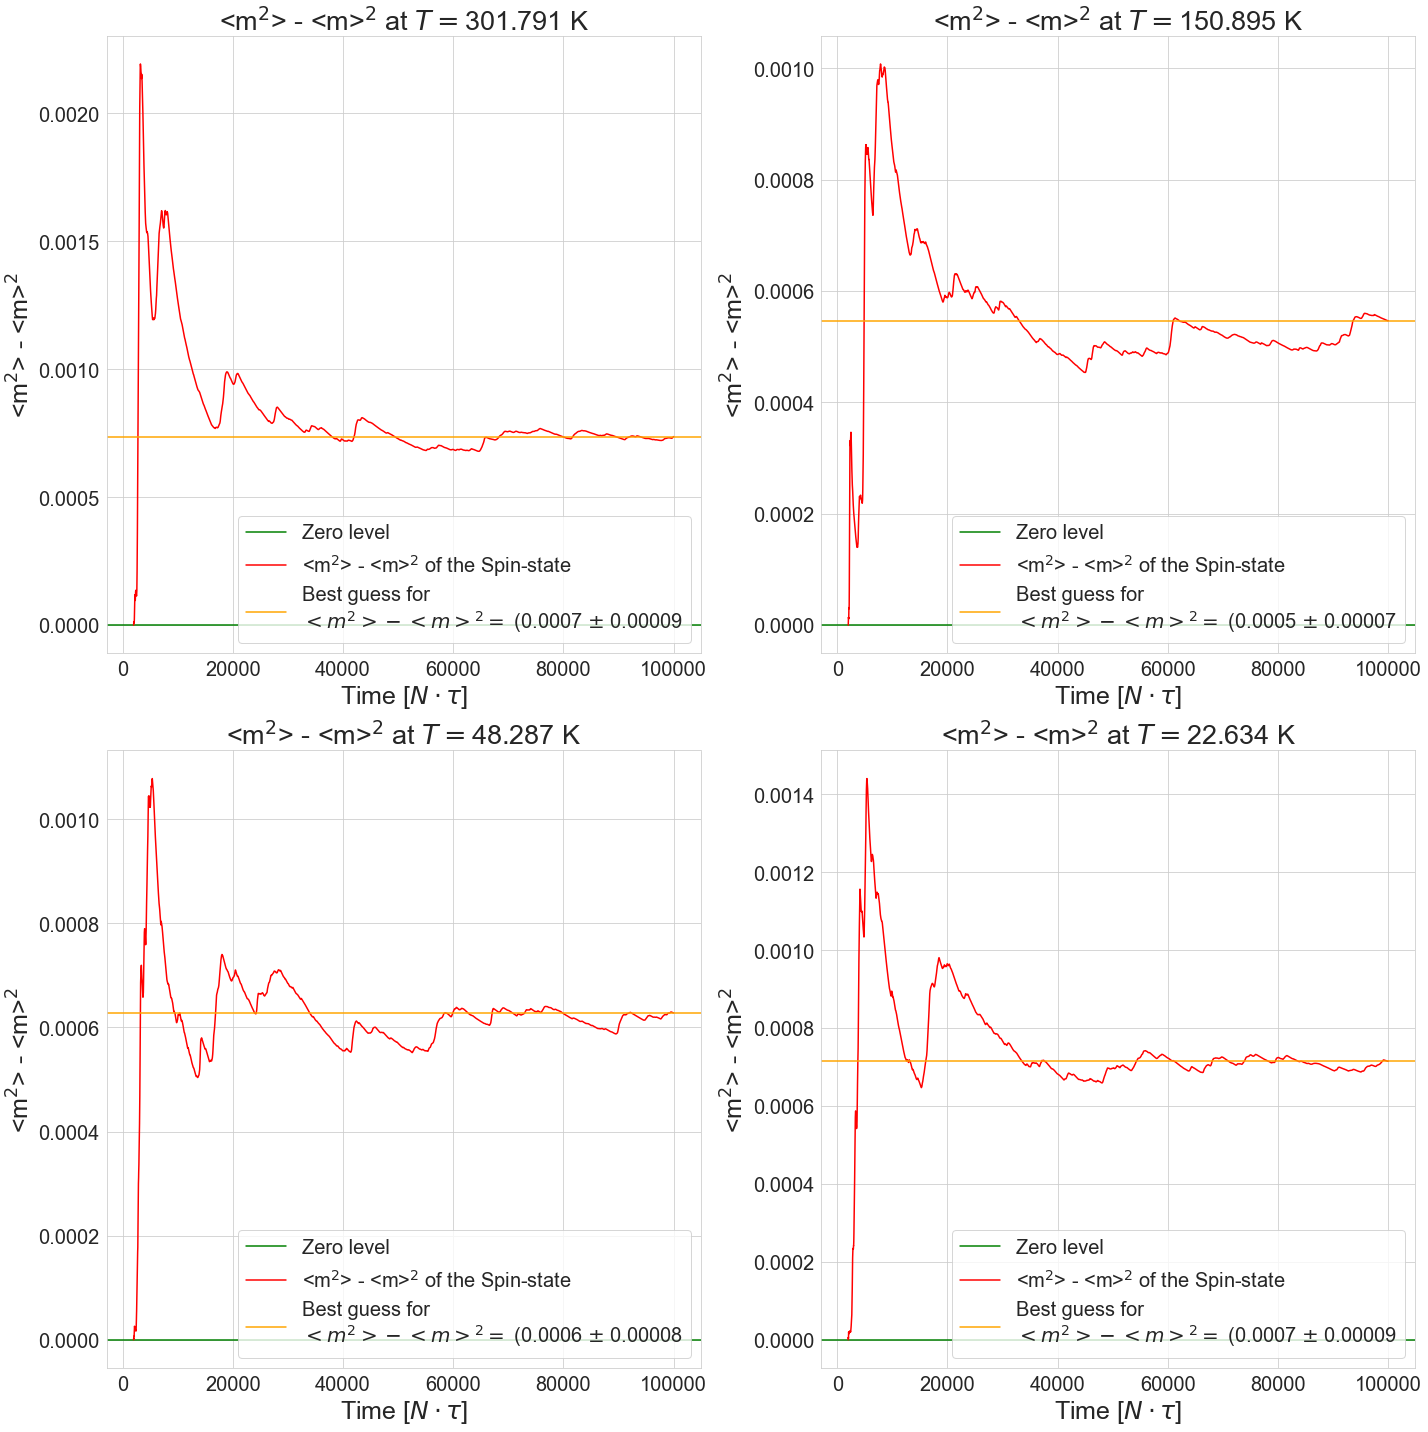

In [46]:
nrows = 2
ncols = 2
figsize = 20
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

titlesize = 27
axislabelsize = 25
axisticksize = 20
legendsize = 20

for i in range(0,nrows):
    for j in range(0,ncols):
        
        magnetization_diff_mean_2D = [(total_magnetization_2D[str(i*nrows + j + 1)]**2)[start_offset_2D:k].mean() -
                                      total_magnetization_2D[str(i*nrows + j + 1)][start_offset_2D:k].mean()**2
                                       for k in range(start_offset_2D + 1, steps_2D+1)]
        
        standard_error_squared_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)/
                                     np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:]**2)))
        
        standard_error_2D = (np.std(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])/
                             np.sqrt(len(total_magnetization_2D[str(i*ncols + j + 1)][start_offset_2D:])))

        axes[i][j].axhline(y=0, color='green', label='Zero level')
        axes[i][j].plot(step_indeces_2D[start_offset_2D + 1:], magnetization_diff_mean_2D, c='red',
                        label='<m$^2$> - <m>$^2$ of the Spin-state')
        
        axes[i][j].axhline(y=magnetization_diff_mean_2D[-1], label='Best guess for\n$<m^2> - <m>^2 =$ ({0:.4f} $\pm$ {1:.5f}'.format(magnetization_diff_mean_2D[-1],
                                                                                                                                     np.sqrt(standard_error_squared_2D**2 + standard_error_2D**2)),
                           color='orange')

        axes[i][j].set_title('<m$^2$> - <m>$^2$ at $T =${0:.3f} K'.format(1 / (betas[str(i*nrows + j + 1)] * k_B)),
                             fontsize=titlesize)

        axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
        axes[i][j].set_ylabel('<m$^2$> - <m>$^2$', fontsize=axislabelsize)

        axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
        axes[i][j].yaxis.get_offset_text().set_fontsize(15)

        axes[i][j].legend(loc='lower right', fontsize=legendsize)
        
fig.tight_layout()
plt.savefig(image_path +
            'magnetization_diff_mean_2D_off' + str(start_offset_2D) + '.' +
            image_format,
            format=image_format,
            dpi=image_dpi,
            bbox_inches='tight')
plt.show()

## Fitting magnetizations
Testing theoretical model if mean magnetization is exponentially decreasing over time
> Only works if offset_2D = 0 !!

### Calculating $<m>$ expected value

In [170]:
if(start_offset_2D == 0):
    p0_fit_2D = {}
    x_fit_2D = {}
    y_fit_2D = {}
    popt_2D = {}
    pcov_2D = {}
    perr_2D = {}

    for i in range(0, len(betas)):
        magnetization_mean_2D = [total_magnetization_2D[str(i+1)][:k].mean()
                                 for k in range(1, steps_2D+1)]

        p0_fit_2D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_2D)

        x_fit_2D[str(i+1)] = step_indeces_2D[1:]
        y_fit_2D[str(i+1)] = magnetization_mean_2D
        popt_2D[str(i+1)], pcov_2D[str(i+1)] = curve_fit(fit_func,
                                                         x_fit_2D[str(i+1)],
                                                         y_fit_2D[str(i+1)],
                                                         p0=p0_fit_2D[str(i+1)])

        perr_2D[str(i+1)] = np.sqrt(np.diag(pcov_2D[str(i+1)]))

In [171]:
if(start_offset_2D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_mean_2D = [(total_magnetization_2D[str(i*ncols + j + 1)])[:k].mean()
                                     for k in range(1, steps_2D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_2D[1:], magnetization_mean_2D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_2D[1:], fit_func(x_fit_2D[str(i*ncols + j + 1)], *popt_2D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_fitted_2D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [172]:
if(start_offset_2D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_2D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_2D[str(i+1)][2]))

### Calculating $<m^{2}>$ expected value

In [173]:
if(start_offset_2D == 0):
    p0_fit_square_2D = {}
    x_fit_square_2D = {}
    y_fit_square_2D = {}
    popt_square_2D = {}
    pcov_square_2D = {}
    perr_square_2D = {}

    for i in range(0, len(betas)):
        magnetization_mean_2D = [(total_magnetization_2D[str(i+1)]**2)[:k].mean()
                                 for k in range(1, steps_2D+1)]
        p0_fit_square_2D[str(i+1)] = value_prep(current_magnetization=magnetization_mean_2D)

        x_fit_square_2D[str(i+1)] = step_indeces_2D[1:]
        y_fit_square_2D[str(i+1)] = magnetization_squared_mean_2D
        popt_square_2D[str(i+1)], pcov_square_2D[str(i+1)] = curve_fit(fit_func,
                                                                       x_fit_square_2D[str(i+1)],
                                                                       y_fit_square_2D[str(i+1)],
                                                                       p0=p0_fit_square_2D[str(i+1)])

        perr_square_2D[str(i+1)] = np.sqrt(np.diag(pcov_square_2D[str(i+1)]))

In [174]:
if(start_offset_2D == 0):
    nrows = 2
    ncols = 2
    figsize = 20
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize,figsize))

    titlesize = 27
    axislabelsize = 25
    axisticksize = 20
    legendsize = 20

    for i in range(0, nrows):
        for j in range(0, ncols):

            magnetization_squared_mean_2D = [(total_magnetization_2D[str(i*ncols + j + 1)]**2)[:k].mean()
                                             for k in range(1, steps_2D+1)]

            axes[i][j].axhline(y=0, color='green', label='Zero level')
            axes[i][j].plot(step_indeces_2D[1:], magnetization_squared_mean_2D, color='red', label='Original funtion')
            axes[i][j].plot(step_indeces_2D[1:], fit_func(x_fit_square_2D[str(i*ncols + j + 1)], *popt_square_2D[str(i*ncols + j + 1)]),
                            color='green', linestyle='--', label='Fitted')

            axes[i][j].set_xlabel('Time [$N \\cdot \\tau$]', fontsize=axislabelsize)
            axes[i][j].set_ylabel('<Magnetization$^2$>', fontsize=axislabelsize)

            axes[i][j].tick_params(axis='both', which='major', labelsize=axisticksize)
            axes[i][j].yaxis.get_offset_text().set_fontsize(15)

            axes[i][j].legend(loc='upper right', fontsize=legendsize)

    plt.savefig(image_path +
                'magnetization_squared_fitted_2D.' +
                image_format,
                format=image_format,
                dpi=image_dpi,
                bbox_inches='tight')
    plt.show()

In [175]:
if(start_offset_2D == 0):
    for i in range(0,len(betas)):
        print('Fit parameters at T = {0:.3f} K:'.format(1 / (betas[str(i + 1)] * k_B)), p0_fit_square_2D[str(i+1)])

    print('\n')

    for i in range(0, len(betas)):
        print('<m^2> at T = {0:.3f} K: {1:.4f}'.format(1 / (betas[str(i + 1)] * k_B), p0_fit_square_2D[str(i+1)][2]))